In [62]:
import numpy as np 
import pandas as pd 
import math

student_sequences = pd.read_csv('data/student_sequences.txt', sep = ',', header = None, names = ['student_id', 'problem_id', 'success_probability', 'score'])
gold_standard_sequences = pd.read_csv('data/gold_standard_sequences.txt', sep = ',', header = None, names = ['student_id', 'problem_id', 'score'])
problem_skill = pd.read_csv('data/problem_skill.txt', sep = ',', header = None, names = ['problem_id', 'skill_id'])

In [63]:
student_sequences

,student_id,problem_id,success_probability,score
0,1,2,1,1
1,2,4,1,1
2,3,13,1,1
3,4,2,1,1
4,5,15,1,1
...,...,...,...,...
3357,75,8,0,0
3358,75,2,0,0
3359,75,8,0,0
3360,75,5,0,0


In [82]:
gold_standard_sequences

,student_id,problem_id,score
0,1,2,1
1,1,17,2
2,1,19,1
3,1,12,2
4,1,5,2
...,...,...,...
3357,75,8,1
3358,75,2,2
3359,75,8,1
3360,75,5,2


In [65]:
problem_skill

,problem_id,skill_id
0,1,1
1,2,2
2,3,3
3,4,1
4,5,2
5,6,3
6,7,1
7,8,1
8,9,2
9,10,1


### Add time step column to the student sequences data

In [66]:
student_sequences['time_step'] = 0

for i in range(75):
    student_sequences.loc[i, 'time_step'] = 1

current_student_id = student_sequences.loc[75, 'student_id']
current_time_step = 1

for i in range(75, len(student_sequences)):
    if student_sequences.loc[i, 'student_id'] == current_student_id:  # same student's record
        current_time_step += 1
    else:  # new student
        current_student_id = student_sequences.loc[i, 'student_id']
        current_time_step = 2

    student_sequences.loc[i, 'time_step'] = current_time_step

In [67]:
student_sequences

,student_id,problem_id,success_probability,score,time_step
0,1,2,1,1,1
1,2,4,1,1,1
2,3,13,1,1,1
3,4,2,1,1,1
4,5,15,1,1,1
...,...,...,...,...,...
3357,75,8,0,0,62
3358,75,2,0,0,63
3359,75,8,0,0,64
3360,75,5,0,0,65


### Add time step column to gold standard sequence

In [83]:
gold_standard_sequences['time_step'] = 0
current_student_id = gold_standard_sequences.loc[0, 'student_id']
current_time_step = 0

for i in range(0, len(gold_standard_sequences)):
    if gold_standard_sequences.loc[i, 'student_id'] == current_student_id:  # same student's record
        current_time_step += 1
    else:  # new student
        current_student_id = gold_standard_sequences.loc[i, 'student_id']
        current_time_step = 2

    gold_standard_sequences.loc[i, 'time_step'] = current_time_step

In [84]:
gold_standard_sequences

,student_id,problem_id,score,time_step
0,1,2,1,1
1,1,17,2,2
2,1,19,1,3
3,1,12,2,4
4,1,5,2,5
...,...,...,...,...
3357,75,8,1,63
3358,75,2,2,64
3359,75,8,1,65
3360,75,5,2,66


In [34]:
def calculate_success_probability(beta_difficulty_level, lambda_success_lr, r_previous_succeed_time, ro_failure_lr, f_previous_fail_time):
    log_x = beta_difficulty_level + lambda_success_lr * r_previous_succeed_time + ro_failure_lr * f_previous_fail_time
    success_probability = np.exp(log_x) / (np.exp(log_x) + 1)
    return success_probability

### Low learning, no-skill PFA

In [35]:
LLNS_student_sequences = student_sequences.copy()

beta_difficulty_level = -0.001
lambda_success_lr = 0.002
ro_failure_lr = 0.001
gamma = 0.5

for i in range(len(LLNS_student_sequences)):
    current_time_step = LLNS_student_sequences.loc[i, 'time_step']
    
    if current_time_step > 1:
        student_id = LLNS_student_sequences.loc[i, 'student_id']
        problem_id = LLNS_student_sequences.loc[i, 'problem_id']
        
        previous_data = LLNS_student_sequences[(LLNS_student_sequences['time_step'] < current_time_step) & (LLNS_student_sequences['student_id'] == student_id) & (LLNS_student_sequences['problem_id'] == problem_id)]
        r_previous_succeed_time = previous_data[previous_data['score'] == 2].shape[0]
        f_previous_fail_time = previous_data[previous_data['score'] == 1].shape[0]
        
        success_probability = calculate_success_probability(beta_difficulty_level, lambda_success_lr, r_previous_succeed_time, ro_failure_lr, f_previous_fail_time)
        LLNS_student_sequences.loc[i, 'success_probability'] = success_probability
        
        if success_probability > gamma:
            LLNS_student_sequences.loc[i, 'score'] = 2
        else:
            LLNS_student_sequences.loc[i, 'score'] = 1
            
LLNS_student_sequences

/var/folders/1v/xyr2tnds2476kj4td8g5brkc0000gn/T/ipykernel_26867/133543110.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.49975000002083336' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  LLNS_student_sequences.loc[i, 'success_probability'] = success_probability


,student_id,problem_id,success_probability,score,time_step
0,1,2,1.00000,1,1
1,2,4,1.00000,1,1
2,3,13,1.00000,1,1
3,4,2,1.00000,1,1
4,5,15,1.00000,1,1
...,...,...,...,...,...
3357,75,8,0.50025,2,62
3358,75,2,0.50075,2,63
3359,75,8,0.50075,2,64
3360,75,5,0.50125,2,65


### High learning, no-skill PFA

In [36]:
HLNS_student_sequences = student_sequences.copy()

beta_difficulty_level = -0.01
lambda_success_lr = 0.8
ro_failure_lr = 0.2
gamma = 0.5

for i in range(len(HLNS_student_sequences)):
    current_time_step = HLNS_student_sequences.loc[i, 'time_step']
    
    if current_time_step > 1:
        student_id = HLNS_student_sequences.loc[i, 'student_id']
        problem_id = HLNS_student_sequences.loc[i, 'problem_id']
        
        previous_data = HLNS_student_sequences[(HLNS_student_sequences['time_step'] < current_time_step) & (HLNS_student_sequences['student_id'] == student_id) & (HLNS_student_sequences['problem_id'] == problem_id)]
        r_previous_succeed_time = previous_data[previous_data['score'] == 2].shape[0]
        f_previous_fail_time = previous_data[previous_data['score'] == 1].shape[0]
        
        success_probability = calculate_success_probability(beta_difficulty_level, lambda_success_lr, r_previous_succeed_time, ro_failure_lr, f_previous_fail_time)
        HLNS_student_sequences.loc[i, 'success_probability'] = success_probability
        
        if success_probability > gamma:
            HLNS_student_sequences.loc[i, 'score'] = 2
        else:
            HLNS_student_sequences.loc[i, 'score'] = 1
            
HLNS_student_sequences

/var/folders/1v/xyr2tnds2476kj4td8g5brkc0000gn/T/ipykernel_26867/2703482056.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.497500020833125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  HLNS_student_sequences.loc[i, 'success_probability'] = success_probability


,student_id,problem_id,success_probability,score,time_step
0,1,2,1.000000,1,1
1,2,4,1.000000,1,1
2,3,13,1.000000,1,1
3,4,2,1.000000,1,1
4,5,15,1.000000,1,1
...,...,...,...,...,...
3357,75,8,0.729088,2,62
3358,75,2,0.856927,2,63
3359,75,8,0.856927,2,64
3360,75,5,0.930215,2,65


### Heterogeneous learning, no-skill PFA

In [37]:
HELNS_student_sequences = student_sequences.copy()

beta_difficulty_level_dict = {}
for problem_id in HELNS_student_sequences['problem_id'].unique():
    beta_difficulty_level_dict[problem_id] = np.random.normal(-0.5, 0.1)

lambda_success_lr = 0.2
ro_failure_lr = 0.05
gamma = 0.5

for i in range(len(HELNS_student_sequences)):
    current_time_step = HELNS_student_sequences.loc[i, 'time_step']
    
    if current_time_step > 1:
        student_id = HELNS_student_sequences.loc[i, 'student_id']
        problem_id = HELNS_student_sequences.loc[i, 'problem_id']
        
        previous_data = HELNS_student_sequences[(HELNS_student_sequences['time_step'] < current_time_step) & (HELNS_student_sequences['student_id'] == student_id) & (HELNS_student_sequences['problem_id'] == problem_id)]
        r_previous_succeed_time = previous_data[previous_data['score'] == 2].shape[0]
        f_previous_fail_time = previous_data[previous_data['score'] == 1].shape[0]
        
        success_probability = calculate_success_probability(beta_difficulty_level, lambda_success_lr, r_previous_succeed_time, ro_failure_lr, f_previous_fail_time)
        HELNS_student_sequences.loc[i, 'success_probability'] = success_probability
        
        if success_probability > gamma:
            HELNS_student_sequences.loc[i, 'score'] = 2
        else:
            HELNS_student_sequences.loc[i, 'score'] = 1

HELNS_student_sequences

/var/folders/1v/xyr2tnds2476kj4td8g5brkc0000gn/T/ipykernel_26867/1847288051.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.497500020833125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  HELNS_student_sequences.loc[i, 'success_probability'] = success_probability


,student_id,problem_id,success_probability,score,time_step
0,1,2,1.000000,1,1
1,2,4,1.000000,1,1
2,3,13,1.000000,1,1
3,4,2,1.000000,1,1
4,5,15,1.000000,1,1
...,...,...,...,...,...
3357,75,8,0.559714,2,62
3358,75,2,0.608259,2,63
3359,75,8,0.608259,2,64
3360,75,5,0.654753,2,65


### Low learning, one-skill PFA

In [38]:
LLOS_student_sequences = student_sequences.copy()

beta_difficulty_level = -0.001
lambda_success_lr = 0.002
ro_failure_lr = 0.001
gamma = 0.5

for i in range(len(LLOS_student_sequences)):
    current_time_step = LLOS_student_sequences.loc[i, 'time_step']
    
    if current_time_step > 1:
        student_id = LLOS_student_sequences.loc[i, 'student_id']
        problem_id = LLOS_student_sequences.loc[i, 'problem_id']

        # get skill id of the current problem
        skill_id = None
        for index, row in problem_skill.iterrows():
            if row['problem_id'] == problem_id:
                skill_id = row['skill_id']
                break
        same_skill_problems = []
        for index, row in problem_skill.iterrows():
            if row['skill_id'] == skill_id:
                same_skill_problems.append(row['problem_id'])
                
        # get previous succeed/fail times of the same-skill problem
        previous_data = LLOS_student_sequences[(LLOS_student_sequences['time_step'] < current_time_step) & (LLOS_student_sequences['student_id'] == student_id)]
        r_previous_succeed_time = 0
        f_previous_fail_time = 0
        for index, row in previous_data.iterrows():
            if row['problem_id'] in same_skill_problems:
                if row['score'] == 2:
                    r_previous_succeed_time += 1
                elif row['score'] == 1:
                    f_previous_fail_time += 1
        
        success_probability = calculate_success_probability(beta_difficulty_level, lambda_success_lr, r_previous_succeed_time, ro_failure_lr, f_previous_fail_time)
        LLOS_student_sequences.loc[i, 'success_probability'] = success_probability
        
        if success_probability > gamma:
            LLOS_student_sequences.loc[i, 'score'] = 2
        else:
            LLOS_student_sequences.loc[i, 'score'] = 1

LLOS_student_sequences

/var/folders/1v/xyr2tnds2476kj4td8g5brkc0000gn/T/ipykernel_26867/3755049139.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  LLOS_student_sequences.loc[i, 'success_probability'] = success_probability


,student_id,problem_id,success_probability,score,time_step
0,1,2,1.000000,1,1
1,2,4,1.000000,1,1
2,3,13,1.000000,1,1
3,4,2,1.000000,1,1
4,5,15,1.000000,1,1
...,...,...,...,...,...
3357,75,8,0.506250,2,62
3358,75,2,0.512747,2,63
3359,75,8,0.506750,2,64
3360,75,5,0.513247,2,65


### High learning, one-skill PFA

In [41]:
HLOS_student_sequences = student_sequences.copy()

beta_difficulty_level = -0.01
lambda_success_lr = 0.8
ro_failure_lr = 0.2
gamma = 0.5

for i in range(len(HLOS_student_sequences)):
    current_time_step = HLOS_student_sequences.loc[i, 'time_step']
    
    if current_time_step > 1:
        student_id = HLOS_student_sequences.loc[i, 'student_id']
        problem_id = HLOS_student_sequences.loc[i, 'problem_id']

        # get skill id of the current problem
        skill_id = None
        for index, row in problem_skill.iterrows():
            if row['problem_id'] == problem_id:
                skill_id = row['skill_id']
                break
        same_skill_problems = []
        for index, row in problem_skill.iterrows():
            if row['skill_id'] == skill_id:
                same_skill_problems.append(row['problem_id'])
                
        # get previous succeed/fail times of the same-skill problem
        previous_data = HLOS_student_sequences[(HLOS_student_sequences['time_step'] < current_time_step) & (HLOS_student_sequences['student_id'] == student_id)]
        r_previous_succeed_time = 0
        f_previous_fail_time = 0
        for index, row in previous_data.iterrows():
            if row['problem_id'] in same_skill_problems:
                if row['score'] == 2:
                    r_previous_succeed_time += 1
                elif row['score'] == 1:
                    f_previous_fail_time += 1
        
        success_probability = calculate_success_probability(beta_difficulty_level, lambda_success_lr, r_previous_succeed_time, ro_failure_lr, f_previous_fail_time)
        HLOS_student_sequences.loc[i, 'success_probability'] = success_probability
        
        if success_probability > gamma:
            HLOS_student_sequences.loc[i, 'score'] = 2
        else:
            HLOS_student_sequences.loc[i, 'score'] = 1

HLOS_student_sequences

/var/folders/1v/xyr2tnds2476kj4td8g5brkc0000gn/T/ipykernel_26867/504450655.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5473576181430893' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  HLOS_student_sequences.loc[i, 'success_probability'] = success_probability


,student_id,problem_id,success_probability,score,time_step
0,1,2,1.000000,1,1
1,2,4,1.000000,1,1
2,3,13,1.000000,1,1
3,4,2,1.000000,1,1
4,5,15,1.000000,1,1
...,...,...,...,...,...
3357,75,8,0.999969,2,62
3358,75,2,1.000000,2,63
3359,75,8,0.999986,2,64
3360,75,5,1.000000,2,65


## Evaluation

In [52]:
def model_evaluation(predicted_sequences, standard_sequences):
    correct_count = 0
    total_count = 0
    square_error_sum = 0
    
    for i in range(len(predicted_sequences)):
        student_id = predicted_sequences.loc[i, 'student_id']
        problem_id = predicted_sequences.loc[i, 'problem_id']
        time_step = predicted_sequences.loc[i, 'time_step']
        predicted_score = predicted_sequences.loc[i, 'score']
        
        ground_truth = None
        for j in range(len(standard_sequences)):
            if (standard_sequences.loc[j, 'student_id'] == student_id) & (standard_sequences.loc[j, 'problem_id'] == problem_id) & (standard_sequences.loc[j, 'time_step'] == time_step):
                ground_truth = standard_sequences.loc[j, 'score']
                break
        if ground_truth is not None:
            total_count += 1
            if predicted_score == ground_truth:
                correct_count += 1
            square_error_sum += (predicted_score - ground_truth) ** 2
        else:
            continue
    
    accuracy = correct_count / total_count
    rmse = (square_error_sum / total_count) ** 0.5
    return accuracy, rmse

In [53]:
accuracy, rmse = model_evaluation(LLNS_student_sequences, gold_standard_sequences)
print(f"The accuracy of Low Learning No-Skill PFA model is: {accuracy}")
print(f"The RMSE of Low Learning No-Skill PFA model is: {rmse}")

The accuracy of Low Learning No-Skill PFA model is: 0.6820276497695853
The RMSE of Low Learning No-Skill PFA model is: 0.5638903707551803


In [54]:
accuracy, rmse = model_evaluation(HLNS_student_sequences, gold_standard_sequences)
print(f"The accuracy of High Learning No-Skill PFA model is: {accuracy}")
print(f"The RMSE of High Learning No-Skill PFA model is: {rmse}")

The accuracy of High Learning No-Skill PFA model is: 0.5852534562211982
The RMSE of High Learning No-Skill PFA model is: 0.6440081861116377


In [55]:
accuracy, rmse = model_evaluation(HELNS_student_sequences, gold_standard_sequences)
print(f"The accuracy of Heterogeneous Learning No-Skill PFA model is: {accuracy}")
print(f"The RMSE of Hererogeneous Learning No-Skill PFA model is: {rmse}")

The accuracy of Heterogeneous Learning No-Skill PFA model is: 0.5852534562211982
The RMSE of Hererogeneous Learning No-Skill PFA model is: 0.6440081861116377


In [56]:
accuracy, rmse = model_evaluation(LLOS_student_sequences, gold_standard_sequences)
print(f"The accuracy of Low Learning One-Skill PFA model is: {accuracy}")
print(f"The RMSE of Low Learning One-Skill PFA model is: {rmse}")

The accuracy of Low Learning One-Skill PFA model is: 0.6728110599078341
The RMSE of Low Learning One-Skill PFA model is: 0.5720043182460828


In [57]:
accuracy, rmse = model_evaluation(HLOS_student_sequences, gold_standard_sequences)
print(f"The accuracy of High Learning One-Skill PFA model is: {accuracy}")
print(f"The RMSE of High Learning One-Skill PFA model is: {rmse}")

The accuracy of High Learning One-Skill PFA model is: 0.6036866359447005
The RMSE of High Learning One-Skill PFA model is: 0.629534243751124


In [68]:
LLNS_student_sequences_small_gamma = student_sequences.copy()

beta_difficulty_level = -0.001
lambda_success_lr = 0.002
ro_failure_lr = 0.001
gamma = 0.3

for i in range(len(LLNS_student_sequences_small_gamma)):
    current_time_step = LLNS_student_sequences_small_gamma.loc[i, 'time_step']
    
    if current_time_step > 1:
        student_id = LLNS_student_sequences_small_gamma.loc[i, 'student_id']
        problem_id = LLNS_student_sequences_small_gamma.loc[i, 'problem_id']
        
        previous_data = LLNS_student_sequences_small_gamma[(LLNS_student_sequences_small_gamma['time_step'] < current_time_step) & (LLNS_student_sequences_small_gamma['student_id'] == student_id) & (LLNS_student_sequences_small_gamma['problem_id'] == problem_id)]
        r_previous_succeed_time = previous_data[previous_data['score'] == 2].shape[0]
        f_previous_fail_time = previous_data[previous_data['score'] == 1].shape[0]
        
        success_probability = calculate_success_probability(beta_difficulty_level, lambda_success_lr, r_previous_succeed_time, ro_failure_lr, f_previous_fail_time)
        LLNS_student_sequences_small_gamma.loc[i, 'success_probability'] = success_probability
        
        if success_probability > gamma:
            LLNS_student_sequences_small_gamma.loc[i, 'score'] = 2
        else:
            LLNS_student_sequences_small_gamma.loc[i, 'score'] = 1
            
LLNS_student_sequences_small_gamma

/var/folders/1v/xyr2tnds2476kj4td8g5brkc0000gn/T/ipykernel_26867/3283896608.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.49975000002083336' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  LLNS_student_sequences_small_gamma.loc[i, 'success_probability'] = success_probability


,student_id,problem_id,success_probability,score,time_step
0,1,2,1.00000,1,1
1,2,4,1.00000,1,1
2,3,13,1.00000,1,1
3,4,2,1.00000,1,1
4,5,15,1.00000,1,1
...,...,...,...,...,...
3357,75,8,0.50075,2,62
3358,75,2,0.50125,2,63
3359,75,8,0.50125,2,64
3360,75,5,0.50175,2,65


In [69]:
LLNS_student_sequences_big_gamma = student_sequences.copy()

beta_difficulty_level = -0.001
lambda_success_lr = 0.002
ro_failure_lr = 0.001
gamma = 0.7

for i in range(len(LLNS_student_sequences_big_gamma)):
    current_time_step = LLNS_student_sequences_big_gamma.loc[i, 'time_step']
    
    if current_time_step > 1:
        student_id = LLNS_student_sequences_big_gamma.loc[i, 'student_id']
        problem_id = LLNS_student_sequences_big_gamma.loc[i, 'problem_id']
        
        previous_data = LLNS_student_sequences_big_gamma[(LLNS_student_sequences_big_gamma['time_step'] < current_time_step) & (LLNS_student_sequences_big_gamma['student_id'] == student_id) & (LLNS_student_sequences_big_gamma['problem_id'] == problem_id)]
        r_previous_succeed_time = previous_data[previous_data['score'] == 2].shape[0]
        f_previous_fail_time = previous_data[previous_data['score'] == 1].shape[0]
        
        success_probability = calculate_success_probability(beta_difficulty_level, lambda_success_lr, r_previous_succeed_time, ro_failure_lr, f_previous_fail_time)
        LLNS_student_sequences_big_gamma.loc[i, 'success_probability'] = success_probability
        
        if success_probability > gamma:
            LLNS_student_sequences_big_gamma.loc[i, 'score'] = 2
        else:
            LLNS_student_sequences_big_gamma.loc[i, 'score'] = 1
            
LLNS_student_sequences_big_gamma

/var/folders/1v/xyr2tnds2476kj4td8g5brkc0000gn/T/ipykernel_26867/3316943992.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.49975000002083336' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  LLNS_student_sequences_big_gamma.loc[i, 'success_probability'] = success_probability


,student_id,problem_id,success_probability,score,time_step
0,1,2,1.00000,1,1
1,2,4,1.00000,1,1
2,3,13,1.00000,1,1
3,4,2,1.00000,1,1
4,5,15,1.00000,1,1
...,...,...,...,...,...
3357,75,8,0.50025,1,62
3358,75,2,0.50050,1,63
3359,75,8,0.50050,1,64
3360,75,5,0.50075,1,65


In [70]:
HLNS_student_sequences_small_gamma = student_sequences.copy()

beta_difficulty_level = -0.01
lambda_success_lr = 0.8
ro_failure_lr = 0.2
gamma = 0.3

for i in range(len(HLNS_student_sequences_small_gamma)):
    current_time_step = HLNS_student_sequences_small_gamma.loc[i, 'time_step']
    
    if current_time_step > 1:
        student_id = HLNS_student_sequences_small_gamma.loc[i, 'student_id']
        problem_id = HLNS_student_sequences_small_gamma.loc[i, 'problem_id']
        
        previous_data = HLNS_student_sequences_small_gamma[(HLNS_student_sequences_small_gamma['time_step'] < current_time_step) & (HLNS_student_sequences_small_gamma['student_id'] == student_id) & (HLNS_student_sequences_small_gamma['problem_id'] == problem_id)]
        r_previous_succeed_time = previous_data[previous_data['score'] == 2].shape[0]
        f_previous_fail_time = previous_data[previous_data['score'] == 1].shape[0]
        
        success_probability = calculate_success_probability(beta_difficulty_level, lambda_success_lr, r_previous_succeed_time, ro_failure_lr, f_previous_fail_time)
        HLNS_student_sequences_small_gamma.loc[i, 'success_probability'] = success_probability
        
        if success_probability > gamma:
            HLNS_student_sequences_small_gamma.loc[i, 'score'] = 2
        else:
            HLNS_student_sequences_small_gamma.loc[i, 'score'] = 1
            
HLNS_student_sequences_small_gamma

/var/folders/1v/xyr2tnds2476kj4td8g5brkc0000gn/T/ipykernel_26867/2286119466.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.497500020833125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  HLNS_student_sequences_small_gamma.loc[i, 'success_probability'] = success_probability


,student_id,problem_id,success_probability,score,time_step
0,1,2,1.000000,1,1
1,2,4,1.000000,1,1
2,3,13,1.000000,1,1
3,4,2,1.000000,1,1
4,5,15,1.000000,1,1
...,...,...,...,...,...
3357,75,8,0.830616,2,62
3358,75,2,0.916062,2,63
3359,75,8,0.916062,2,64
3360,75,5,0.960456,2,65


In [72]:
HLNS_student_sequences_big_gamma = student_sequences.copy()

beta_difficulty_level = -0.01
lambda_success_lr = 0.8
ro_failure_lr = 0.2
gamma = 0.7

for i in range(len(HLNS_student_sequences_big_gamma)):
    current_time_step = HLNS_student_sequences_big_gamma.loc[i, 'time_step']
    
    if current_time_step > 1:
        student_id = HLNS_student_sequences_big_gamma.loc[i, 'student_id']
        problem_id = HLNS_student_sequences_big_gamma.loc[i, 'problem_id']
        
        previous_data = HLNS_student_sequences_big_gamma[(HLNS_student_sequences_big_gamma['time_step'] < current_time_step) & (HLNS_student_sequences_big_gamma['student_id'] == student_id) & (HLNS_student_sequences_big_gamma['problem_id'] == problem_id)]
        r_previous_succeed_time = previous_data[previous_data['score'] == 2].shape[0]
        f_previous_fail_time = previous_data[previous_data['score'] == 1].shape[0]
        
        success_probability = calculate_success_probability(beta_difficulty_level, lambda_success_lr, r_previous_succeed_time, ro_failure_lr, f_previous_fail_time)
        HLNS_student_sequences_big_gamma.loc[i, 'success_probability'] = success_probability
        
        if success_probability > gamma:
            HLNS_student_sequences_big_gamma.loc[i, 'score'] = 2
        else:
            HLNS_student_sequences_big_gamma.loc[i, 'score'] = 1
            
HLNS_student_sequences_big_gamma

/var/folders/1v/xyr2tnds2476kj4td8g5brkc0000gn/T/ipykernel_26867/2595845456.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.497500020833125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  HLNS_student_sequences_big_gamma.loc[i, 'success_probability'] = success_probability


,student_id,problem_id,success_probability,score,time_step
0,1,2,1.000000,1,1
1,2,4,1.000000,1,1
2,3,13,1.000000,1,1
3,4,2,1.000000,1,1
4,5,15,1.000000,1,1
...,...,...,...,...,...
3357,75,8,0.596283,1,62
3358,75,2,0.643365,1,63
3359,75,8,0.643365,1,64
3360,75,5,0.687831,1,65


In [75]:
HELNS_student_sequences_small_gamma = student_sequences.copy()

beta_difficulty_level_dict = {}
for problem_id in HELNS_student_sequences_small_gamma['problem_id'].unique():
    beta_difficulty_level_dict[problem_id] = np.random.normal(-0.5, 0.1)

lambda_success_lr = 0.2
ro_failure_lr = 0.05
gamma = 0.3

for i in range(len(HELNS_student_sequences_small_gamma)):
    current_time_step = HELNS_student_sequences_small_gamma.loc[i, 'time_step']
    
    if current_time_step > 1:
        student_id = HELNS_student_sequences_small_gamma.loc[i, 'student_id']
        problem_id = HELNS_student_sequences_small_gamma.loc[i, 'problem_id']
        
        previous_data = HELNS_student_sequences_small_gamma[(HELNS_student_sequences_small_gamma['time_step'] < current_time_step) & (HELNS_student_sequences_small_gamma['student_id'] == student_id) & (HELNS_student_sequences_small_gamma['problem_id'] == problem_id)]
        r_previous_succeed_time = previous_data[previous_data['score'] == 2].shape[0]
        f_previous_fail_time = previous_data[previous_data['score'] == 1].shape[0]
        
        success_probability = calculate_success_probability(beta_difficulty_level, lambda_success_lr, r_previous_succeed_time, ro_failure_lr, f_previous_fail_time)
        HELNS_student_sequences_small_gamma.loc[i, 'success_probability'] = success_probability
        
        if success_probability > gamma:
            HELNS_student_sequences_small_gamma.loc[i, 'score'] = 2
        else:
            HELNS_student_sequences_small_gamma.loc[i, 'score'] = 1

HELNS_student_sequences_small_gamma

/var/folders/1v/xyr2tnds2476kj4td8g5brkc0000gn/T/ipykernel_26867/2992267391.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.497500020833125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  HELNS_student_sequences_small_gamma.loc[i, 'success_probability'] = success_probability


,student_id,problem_id,success_probability,score,time_step
0,1,2,1.000000,1,1
1,2,4,1.000000,1,1
2,3,13,1.000000,1,1
3,4,2,1.000000,1,1
4,5,15,1.000000,1,1
...,...,...,...,...,...
3357,75,8,0.596283,2,62
3358,75,2,0.643365,2,63
3359,75,8,0.643365,2,64
3360,75,5,0.687831,2,65


In [76]:
HELNS_student_sequences_big_gamma = student_sequences.copy()

beta_difficulty_level_dict = {}
for problem_id in HELNS_student_sequences_big_gamma['problem_id'].unique():
    beta_difficulty_level_dict[problem_id] = np.random.normal(-0.5, 0.1)

lambda_success_lr = 0.2
ro_failure_lr = 0.05
gamma = 0.7

for i in range(len(HELNS_student_sequences_big_gamma)):
    current_time_step = HELNS_student_sequences_big_gamma.loc[i, 'time_step']
    
    if current_time_step > 1:
        student_id = HELNS_student_sequences_big_gamma.loc[i, 'student_id']
        problem_id = HELNS_student_sequences_big_gamma.loc[i, 'problem_id']
        
        previous_data = HELNS_student_sequences_big_gamma[(HELNS_student_sequences_big_gamma['time_step'] < current_time_step) & (HELNS_student_sequences_big_gamma['student_id'] == student_id) & (HELNS_student_sequences_big_gamma['problem_id'] == problem_id)]
        r_previous_succeed_time = previous_data[previous_data['score'] == 2].shape[0]
        f_previous_fail_time = previous_data[previous_data['score'] == 1].shape[0]
        
        success_probability = calculate_success_probability(beta_difficulty_level, lambda_success_lr, r_previous_succeed_time, ro_failure_lr, f_previous_fail_time)
        HELNS_student_sequences_big_gamma.loc[i, 'success_probability'] = success_probability
        
        if success_probability > gamma:
            HELNS_student_sequences_big_gamma.loc[i, 'score'] = 2
        else:
            HELNS_student_sequences_big_gamma.loc[i, 'score'] = 1

HELNS_student_sequences_big_gamma

/var/folders/1v/xyr2tnds2476kj4td8g5brkc0000gn/T/ipykernel_26867/3822298235.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.497500020833125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  HELNS_student_sequences_big_gamma.loc[i, 'success_probability'] = success_probability


,student_id,problem_id,success_probability,score,time_step
0,1,2,1.000000,1,1
1,2,4,1.000000,1,1
2,3,13,1.000000,1,1
3,4,2,1.000000,1,1
4,5,15,1.000000,1,1
...,...,...,...,...,...
3357,75,8,0.522485,1,62
3358,75,2,0.534943,1,63
3359,75,8,0.534943,1,64
3360,75,5,0.547358,1,65


In [77]:
LLOS_student_sequences_small_gamma = student_sequences.copy()

beta_difficulty_level = -0.001
lambda_success_lr = 0.002
ro_failure_lr = 0.001
gamma = 0.3

for i in range(len(LLOS_student_sequences_small_gamma)):
    current_time_step = LLOS_student_sequences_small_gamma.loc[i, 'time_step']
    
    if current_time_step > 1:
        student_id = LLOS_student_sequences_small_gamma.loc[i, 'student_id']
        problem_id = LLOS_student_sequences_small_gamma.loc[i, 'problem_id']

        # get skill id of the current problem
        skill_id = None
        for index, row in problem_skill.iterrows():
            if row['problem_id'] == problem_id:
                skill_id = row['skill_id']
                break
        same_skill_problems = []
        for index, row in problem_skill.iterrows():
            if row['skill_id'] == skill_id:
                same_skill_problems.append(row['problem_id'])
                
        # get previous succeed/fail times of the same-skill problem
        previous_data = LLOS_student_sequences_small_gamma[(LLOS_student_sequences_small_gamma['time_step'] < current_time_step) & (LLOS_student_sequences_small_gamma['student_id'] == student_id)]
        r_previous_succeed_time = 0
        f_previous_fail_time = 0
        for index, row in previous_data.iterrows():
            if row['problem_id'] in same_skill_problems:
                if row['score'] == 2:
                    r_previous_succeed_time += 1
                elif row['score'] == 1:
                    f_previous_fail_time += 1
        
        success_probability = calculate_success_probability(beta_difficulty_level, lambda_success_lr, r_previous_succeed_time, ro_failure_lr, f_previous_fail_time)
        LLOS_student_sequences_small_gamma.loc[i, 'success_probability'] = success_probability
        
        if success_probability > gamma:
            LLOS_student_sequences_small_gamma.loc[i, 'score'] = 2
        else:
            LLOS_student_sequences_small_gamma.loc[i, 'score'] = 1

LLOS_student_sequences_small_gamma

/var/folders/1v/xyr2tnds2476kj4td8g5brkc0000gn/T/ipykernel_26867/2467518393.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  LLOS_student_sequences_small_gamma.loc[i, 'success_probability'] = success_probability


,student_id,problem_id,success_probability,score,time_step
0,1,2,1.000000,1,1
1,2,4,1.000000,1,1
2,3,13,1.000000,1,1
3,4,2,1.000000,1,1
4,5,15,1.000000,1,1
...,...,...,...,...,...
3357,75,8,0.506250,2,62
3358,75,2,0.513247,2,63
3359,75,8,0.506750,2,64
3360,75,5,0.513747,2,65


In [78]:
LLOS_student_sequences_big_gamma = student_sequences.copy()

beta_difficulty_level = -0.001
lambda_success_lr = 0.002
ro_failure_lr = 0.001
gamma = 0.7

for i in range(len(LLOS_student_sequences_big_gamma)):
    current_time_step = LLOS_student_sequences_big_gamma.loc[i, 'time_step']
    
    if current_time_step > 1:
        student_id = LLOS_student_sequences_big_gamma.loc[i, 'student_id']
        problem_id = LLOS_student_sequences_big_gamma.loc[i, 'problem_id']

        # get skill id of the current problem
        skill_id = None
        for index, row in problem_skill.iterrows():
            if row['problem_id'] == problem_id:
                skill_id = row['skill_id']
                break
        same_skill_problems = []
        for index, row in problem_skill.iterrows():
            if row['skill_id'] == skill_id:
                same_skill_problems.append(row['problem_id'])
                
        # get previous succeed/fail times of the same-skill problem
        previous_data = LLOS_student_sequences_big_gamma[(LLOS_student_sequences_big_gamma['time_step'] < current_time_step) & (LLOS_student_sequences_big_gamma['student_id'] == student_id)]
        r_previous_succeed_time = 0
        f_previous_fail_time = 0
        for index, row in previous_data.iterrows():
            if row['problem_id'] in same_skill_problems:
                if row['score'] == 2:
                    r_previous_succeed_time += 1
                elif row['score'] == 1:
                    f_previous_fail_time += 1
        
        success_probability = calculate_success_probability(beta_difficulty_level, lambda_success_lr, r_previous_succeed_time, ro_failure_lr, f_previous_fail_time)
        LLOS_student_sequences_big_gamma.loc[i, 'success_probability'] = success_probability
        
        if success_probability > gamma:
            LLOS_student_sequences_big_gamma.loc[i, 'score'] = 2
        else:
            LLOS_student_sequences_big_gamma.loc[i, 'score'] = 1

LLOS_student_sequences_big_gamma

/var/folders/1v/xyr2tnds2476kj4td8g5brkc0000gn/T/ipykernel_26867/1185852985.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  LLOS_student_sequences_big_gamma.loc[i, 'success_probability'] = success_probability


,student_id,problem_id,success_probability,score,time_step
0,1,2,1.00000,1,1
1,2,4,1.00000,1,1
2,3,13,1.00000,1,1
3,4,2,1.00000,1,1
4,5,15,1.00000,1,1
...,...,...,...,...,...
3357,75,8,0.50325,1,62
3358,75,2,0.50650,1,63
3359,75,8,0.50350,1,64
3360,75,5,0.50675,1,65


In [79]:
HLOS_student_sequences_small_gamma = student_sequences.copy()

beta_difficulty_level = -0.01
lambda_success_lr = 0.8
ro_failure_lr = 0.2
gamma = 0.3

for i in range(len(HLOS_student_sequences_small_gamma)):
    current_time_step = HLOS_student_sequences_small_gamma.loc[i, 'time_step']
    
    if current_time_step > 1:
        student_id = HLOS_student_sequences_small_gamma.loc[i, 'student_id']
        problem_id = HLOS_student_sequences_small_gamma.loc[i, 'problem_id']

        # get skill id of the current problem
        skill_id = None
        for index, row in problem_skill.iterrows():
            if row['problem_id'] == problem_id:
                skill_id = row['skill_id']
                break
        same_skill_problems = []
        for index, row in problem_skill.iterrows():
            if row['skill_id'] == skill_id:
                same_skill_problems.append(row['problem_id'])
                
        # get previous succeed/fail times of the same-skill problem
        previous_data = HLOS_student_sequences_small_gamma[(HLOS_student_sequences_small_gamma['time_step'] < current_time_step) & (HLOS_student_sequences_small_gamma['student_id'] == student_id)]
        r_previous_succeed_time = 0
        f_previous_fail_time = 0
        for index, row in previous_data.iterrows():
            if row['problem_id'] in same_skill_problems:
                if row['score'] == 2:
                    r_previous_succeed_time += 1
                elif row['score'] == 1:
                    f_previous_fail_time += 1
        
        success_probability = calculate_success_probability(beta_difficulty_level, lambda_success_lr, r_previous_succeed_time, ro_failure_lr, f_previous_fail_time)
        HLOS_student_sequences_small_gamma.loc[i, 'success_probability'] = success_probability
        
        if success_probability > gamma:
            HLOS_student_sequences_small_gamma.loc[i, 'score'] = 2
        else:
            HLOS_student_sequences_small_gamma.loc[i, 'score'] = 1

HLOS_student_sequences_small_gamma

/var/folders/1v/xyr2tnds2476kj4td8g5brkc0000gn/T/ipykernel_26867/1981757510.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5473576181430893' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  HLOS_student_sequences_small_gamma.loc[i, 'success_probability'] = success_probability


,student_id,problem_id,success_probability,score,time_step
0,1,2,1.000000,1,1
1,2,4,1.000000,1,1
2,3,13,1.000000,1,1
3,4,2,1.000000,1,1
4,5,15,1.000000,1,1
...,...,...,...,...,...
3357,75,8,0.999969,2,62
3358,75,2,1.000000,2,63
3359,75,8,0.999986,2,64
3360,75,5,1.000000,2,65


In [80]:
HLOS_student_sequences_big_gamma = student_sequences.copy()

beta_difficulty_level = -0.01
lambda_success_lr = 0.8
ro_failure_lr = 0.2
gamma = 0.7

for i in range(len(HLOS_student_sequences_big_gamma)):
    current_time_step = HLOS_student_sequences_big_gamma.loc[i, 'time_step']
    
    if current_time_step > 1:
        student_id = HLOS_student_sequences_big_gamma.loc[i, 'student_id']
        problem_id = HLOS_student_sequences_big_gamma.loc[i, 'problem_id']

        # get skill id of the current problem
        skill_id = None
        for index, row in problem_skill.iterrows():
            if row['problem_id'] == problem_id:
                skill_id = row['skill_id']
                break
        same_skill_problems = []
        for index, row in problem_skill.iterrows():
            if row['skill_id'] == skill_id:
                same_skill_problems.append(row['problem_id'])
                
        # get previous succeed/fail times of the same-skill problem
        previous_data = HLOS_student_sequences_big_gamma[(HLOS_student_sequences_big_gamma['time_step'] < current_time_step) & (HLOS_student_sequences_big_gamma['student_id'] == student_id)]
        r_previous_succeed_time = 0
        f_previous_fail_time = 0
        for index, row in previous_data.iterrows():
            if row['problem_id'] in same_skill_problems:
                if row['score'] == 2:
                    r_previous_succeed_time += 1
                elif row['score'] == 1:
                    f_previous_fail_time += 1
        
        success_probability = calculate_success_probability(beta_difficulty_level, lambda_success_lr, r_previous_succeed_time, ro_failure_lr, f_previous_fail_time)
        HLOS_student_sequences_big_gamma.loc[i, 'success_probability'] = success_probability
        
        if success_probability > gamma:
            HLOS_student_sequences_big_gamma.loc[i, 'score'] = 2
        else:
            HLOS_student_sequences_big_gamma.loc[i, 'score'] = 1

HLOS_student_sequences_big_gamma

/var/folders/1v/xyr2tnds2476kj4td8g5brkc0000gn/T/ipykernel_26867/2905034292.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5473576181430893' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  HLOS_student_sequences_big_gamma.loc[i, 'success_probability'] = success_probability


,student_id,problem_id,success_probability,score,time_step
0,1,2,1.000000,1,1
1,2,4,1.000000,1,1
2,3,13,1.000000,1,1
3,4,2,1.000000,1,1
4,5,15,1.000000,1,1
...,...,...,...,...,...
3357,75,8,0.999944,2,62
3358,75,2,1.000000,2,63
3359,75,8,0.999975,2,64
3360,75,5,1.000000,2,65


In [86]:
accuracy, rmse = model_evaluation(LLNS_student_sequences_small_gamma, gold_standard_sequences)
print(f"The accuracy of Low Learning No-Skill PFA model (small gamma) is: {accuracy}")
print(f"The RMSE of Low Learning No-Skill PFA model (small gamma) is: {rmse}")

The accuracy of Low Learning No-Skill PFA model (small gamma) is: 0.5898617511520737
The RMSE of Low Learning No-Skill PFA model (small gamma) is: 0.6404203688577732


In [87]:
accuracy, rmse = model_evaluation(LLNS_student_sequences_big_gamma, gold_standard_sequences)
print(f"The accuracy of Low Learning No-Skill PFA model (big gamma) is: {accuracy}")
print(f"The RMSE of Low Learning No-Skill PFA model (big gamma) is: {rmse}")

The accuracy of Low Learning No-Skill PFA model (big gamma) is: 0.4147465437788018
The RMSE of Low Learning No-Skill PFA model (big gamma) is: 0.7650185986113005


In [88]:
accuracy, rmse = model_evaluation(HLNS_student_sequences_small_gamma, gold_standard_sequences)
print(f"The accuracy of High Learning No-Skill PFA model (small gamma) is: {accuracy}")
print(f"The RMSE of Low Learning No-Skill PFA model (small gamma) is: {rmse}")

The accuracy of High Learning No-Skill PFA model (small gamma) is: 0.5898617511520737
The RMSE of Low Learning No-Skill PFA model (small gamma) is: 0.6404203688577732


In [89]:
accuracy, rmse = model_evaluation(HLNS_student_sequences_big_gamma, gold_standard_sequences)
print(f"The accuracy of High Learning No-Skill PFA model (big gamma) is: {accuracy}")
print(f"The RMSE of Low Learning No-Skill PFA model (big gamma) is: {rmse}")

The accuracy of High Learning No-Skill PFA model (big gamma) is: 0.4700460829493088
The RMSE of Low Learning No-Skill PFA model (big gamma) is: 0.7279793383405131


In [90]:
accuracy, rmse = model_evaluation(HELNS_student_sequences_small_gamma, gold_standard_sequences)
print(f"The accuracy of Heterogeneous Learning No-Skill PFA model (small gamma) is: {accuracy}")
print(f"The RMSE of Heterogeneous Learning No-Skill PFA model (small gamma) is: {rmse}")

The accuracy of Heterogeneous Learning No-Skill PFA model (small gamma) is: 0.5898617511520737
The RMSE of Heterogeneous Learning No-Skill PFA model (small gamma) is: 0.6404203688577732


In [91]:
accuracy, rmse = model_evaluation(HELNS_student_sequences_big_gamma, gold_standard_sequences)
print(f"The accuracy of Heterogeneous Learning No-Skill PFA model (big gamma) is: {accuracy}")
print(f"The RMSE of Heterogeneous Learning No-Skill PFA model (big gamma) is: {rmse}")


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)

The accuracy of Heterogeneous Learning No-Skill PFA model (big gamma) is: 0.4147465437788018
The RMSE of Heterogeneous Learning No-Skill PFA model (big gamma) is: 0.7650185986113005


In [92]:
accuracy, rmse = model_evaluation(LLOS_student_sequences_small_gamma, gold_standard_sequences)
print(f"The accuracy of Low Learning One-Skill PFA model (small gamma) is: {accuracy}")
print(f"The RMSE of Low Learning One-Skill PFA model (small gamma) is: {rmse}")

The accuracy of Low Learning One-Skill PFA model (small gamma) is: 0.5898617511520737
The RMSE of Low Learning One-Skill PFA model (small gamma) is: 0.6404203688577732


In [93]:
accuracy, rmse = model_evaluation(LLOS_student_sequences_big_gamma, gold_standard_sequences)
print(f"The accuracy of Low Learning One-Skill PFA model (big gamma) is: {accuracy}")
print(f"The RMSE of Low Learning One-Skill PFA model (big gamma) is: {rmse}")

The accuracy of Low Learning One-Skill PFA model (big gamma) is: 0.4147465437788018
The RMSE of Low Learning One-Skill PFA model (big gamma) is: 0.7650185986113005


In [94]:
accuracy, rmse = model_evaluation(HLOS_student_sequences_small_gamma, gold_standard_sequences)
print(f"The accuracy of High Learning One-Skill PFA model (small gamma) is: {accuracy}")
print(f"The RMSE of High Learning One-Skill PFA model (small gamma) is: {rmse}")

The accuracy of High Learning One-Skill PFA model (small gamma) is: 0.5898617511520737
The RMSE of High Learning One-Skill PFA model (small gamma) is: 0.6404203688577732


In [95]:
accuracy, rmse = model_evaluation(HLOS_student_sequences_big_gamma, gold_standard_sequences)
print(f"The accuracy of High Learning One-Skill PFA model (big gamma) is: {accuracy}")
print(f"The RMSE of High Learning One-Skill PFA model (big gamma) is: {rmse}")

The accuracy of High Learning One-Skill PFA model (big gamma) is: 0.7880184331797235
The RMSE of High Learning One-Skill PFA model (big gamma) is: 0.46041455973967255


## Plot

### Figure 1

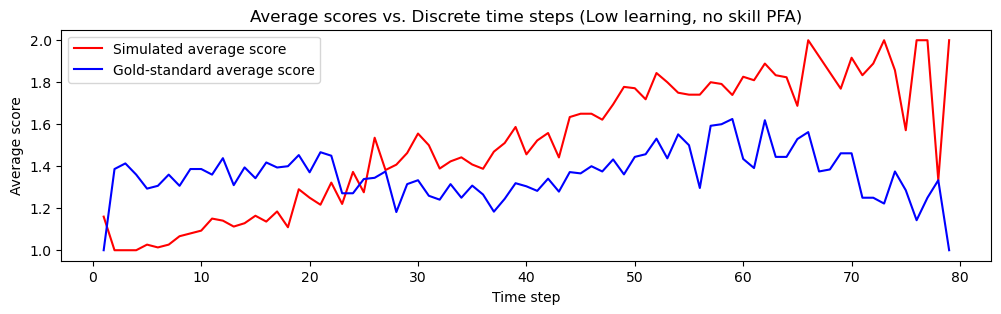

In [125]:
import matplotlib.pyplot as plt

simulated_average_score_list = []
gold_standard_average_score_list = []
time_step_list = sorted(LLNS_student_sequences['time_step'].unique())

for time_step in time_step_list:
    simulated_score = LLNS_student_sequences[LLNS_student_sequences['time_step'] == time_step]['score']
    if len(simulated_score) > 0:
        simulated_average_score = sum(simulated_score) / len(simulated_score)
    else:
        simulated_average_score = 0
    simulated_average_score_list.append(simulated_average_score)
    
    gold_standard_score = LLNS_student_sequences[gold_standard_sequences['time_step'] == time_step]['score']
    if len(gold_standard_score) > 0:
        gold_standard_average_score = sum(gold_standard_score) / len(gold_standard_score)
    else:
        gold_standard_average_score = 0
    gold_standard_average_score_list.append(gold_standard_average_score)

plt.figure(figsize = (12, 3))
plt.plot(time_step_list, simulated_average_score_list, label = 'Simulated average score', color = 'red')
plt.plot(time_step_list, gold_standard_average_score_list, label = 'Gold-standard average score', color = 'blue')
plt.title('Average scores vs. Discrete time steps (Low learning, no skill PFA)')
plt.xlabel('Time step')
plt.ylabel('Average score')
plt.legend()
plt.show()

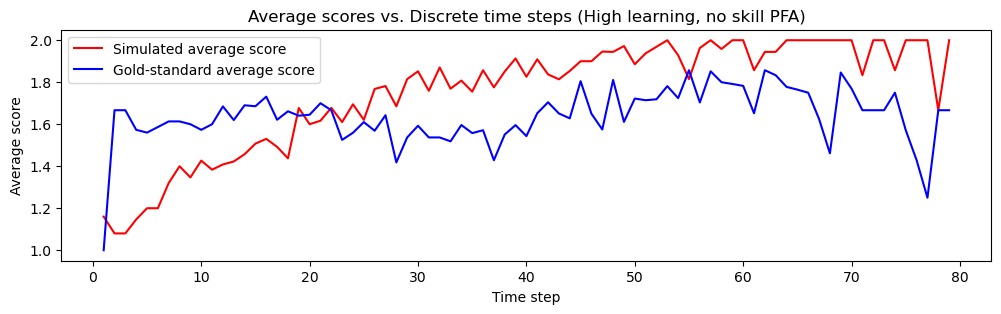

In [126]:
import matplotlib.pyplot as plt

simulated_average_score_list = []
gold_standard_average_score_list = []
time_step_list = sorted(HLNS_student_sequences['time_step'].unique())

for time_step in time_step_list:
    simulated_score = HLNS_student_sequences[HLNS_student_sequences['time_step'] == time_step]['score']
    if len(simulated_score) > 0:
        simulated_average_score = sum(simulated_score) / len(simulated_score)
    else:
        simulated_average_score = 0
    simulated_average_score_list.append(simulated_average_score)
    
    gold_standard_score = HLNS_student_sequences[gold_standard_sequences['time_step'] == time_step]['score']
    if len(gold_standard_score) > 0:
        gold_standard_average_score = sum(gold_standard_score) / len(gold_standard_score)
    else:
        gold_standard_average_score = 0
    gold_standard_average_score_list.append(gold_standard_average_score)

plt.figure(figsize = (12, 3))
plt.plot(time_step_list, simulated_average_score_list, label = 'Simulated average score', color = 'red')
plt.plot(time_step_list, gold_standard_average_score_list, label = 'Gold-standard average score', color = 'blue')
plt.title('Average scores vs. Discrete time steps (High learning, no skill PFA)')
plt.xlabel('Time step')
plt.ylabel('Average score')
plt.legend()
plt.show()

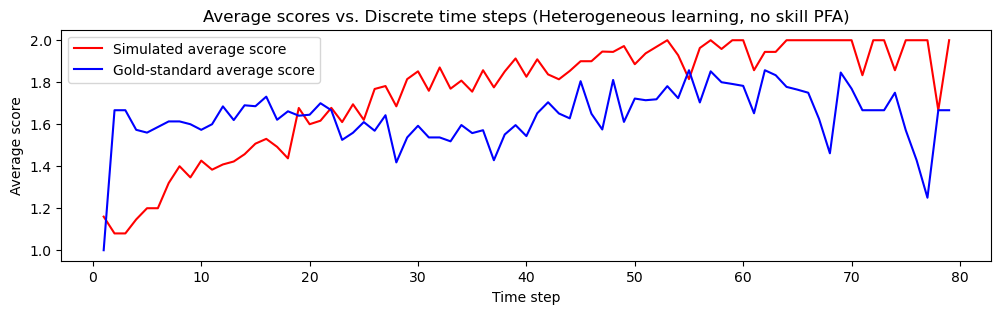

In [127]:
import matplotlib.pyplot as plt

simulated_average_score_list = []
gold_standard_average_score_list = []
time_step_list = sorted(HELNS_student_sequences['time_step'].unique())

for time_step in time_step_list:
    simulated_score = HELNS_student_sequences[HELNS_student_sequences['time_step'] == time_step]['score']
    if len(simulated_score) > 0:
        simulated_average_score = sum(simulated_score) / len(simulated_score)
    else:
        simulated_average_score = 0
    simulated_average_score_list.append(simulated_average_score)
    
    gold_standard_score = HELNS_student_sequences[gold_standard_sequences['time_step'] == time_step]['score']
    if len(gold_standard_score) > 0:
        gold_standard_average_score = sum(gold_standard_score) / len(gold_standard_score)
    else:
        gold_standard_average_score = 0
    gold_standard_average_score_list.append(gold_standard_average_score)

plt.figure(figsize = (12, 3))
plt.plot(time_step_list, simulated_average_score_list, label = 'Simulated average score', color = 'red')
plt.plot(time_step_list, gold_standard_average_score_list, label = 'Gold-standard average score', color = 'blue')
plt.title('Average scores vs. Discrete time steps (Heterogeneous learning, no skill PFA)')
plt.xlabel('Time step')
plt.ylabel('Average score')
plt.legend()
plt.show()

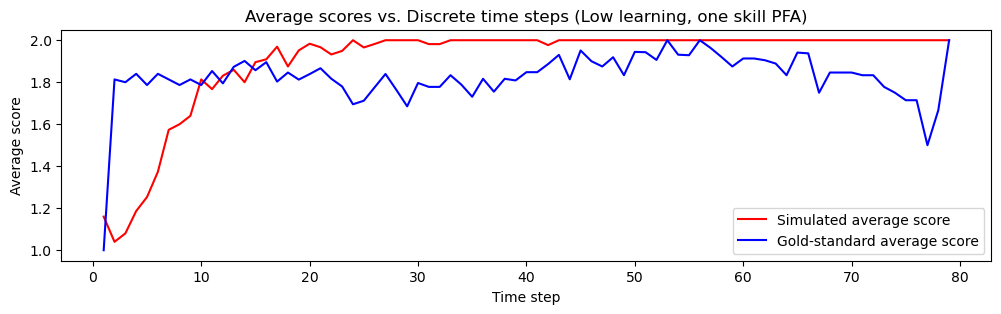

In [128]:
import matplotlib.pyplot as plt

simulated_average_score_list = []
gold_standard_average_score_list = []
time_step_list = sorted(LLOS_student_sequences['time_step'].unique())

for time_step in time_step_list:
    simulated_score = LLOS_student_sequences[LLOS_student_sequences['time_step'] == time_step]['score']
    if len(simulated_score) > 0:
        simulated_average_score = sum(simulated_score) / len(simulated_score)
    else:
        simulated_average_score = 0
    simulated_average_score_list.append(simulated_average_score)
    
    gold_standard_score = LLOS_student_sequences[gold_standard_sequences['time_step'] == time_step]['score']
    if len(gold_standard_score) > 0:
        gold_standard_average_score = sum(gold_standard_score) / len(gold_standard_score)
    else:
        gold_standard_average_score = 0
    gold_standard_average_score_list.append(gold_standard_average_score)

plt.figure(figsize = (12, 3))
plt.plot(time_step_list, simulated_average_score_list, label = 'Simulated average score', color = 'red')
plt.plot(time_step_list, gold_standard_average_score_list, label = 'Gold-standard average score', color = 'blue')
plt.title('Average scores vs. Discrete time steps (Low learning, one skill PFA)')
plt.xlabel('Time step')
plt.ylabel('Average score')
plt.legend()
plt.show()

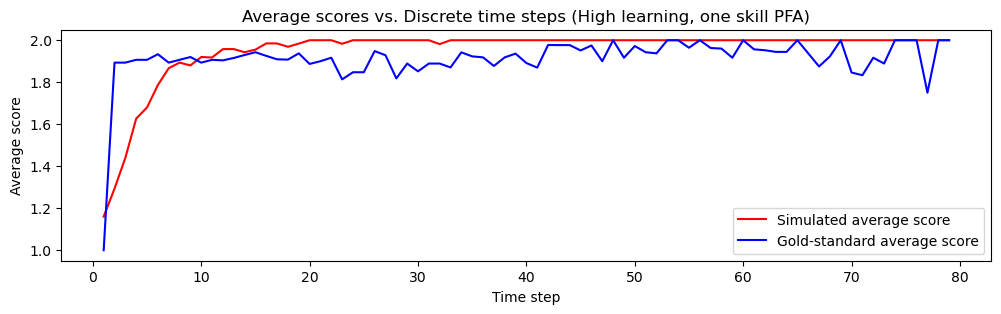

In [129]:
import matplotlib.pyplot as plt

simulated_average_score_list = []
gold_standard_average_score_list = []
time_step_list = sorted(HLOS_student_sequences['time_step'].unique())

for time_step in time_step_list:
    simulated_score = HLOS_student_sequences[HLOS_student_sequences['time_step'] == time_step]['score']
    if len(simulated_score) > 0:
        simulated_average_score = sum(simulated_score) / len(simulated_score)
    else:
        simulated_average_score = 0
    simulated_average_score_list.append(simulated_average_score)
    
    gold_standard_score = HLOS_student_sequences[gold_standard_sequences['time_step'] == time_step]['score']
    if len(gold_standard_score) > 0:
        gold_standard_average_score = sum(gold_standard_score) / len(gold_standard_score)
    else:
        gold_standard_average_score = 0
    gold_standard_average_score_list.append(gold_standard_average_score)

plt.figure(figsize = (12, 3))
plt.plot(time_step_list, simulated_average_score_list, label = 'Simulated average score', color = 'red')
plt.plot(time_step_list, gold_standard_average_score_list, label = 'Gold-standard average score', color = 'blue')
plt.title('Average scores vs. Discrete time steps (High learning, one skill PFA)')
plt.xlabel('Time step')
plt.ylabel('Average score')
plt.legend()
plt.show()

### Figure 2

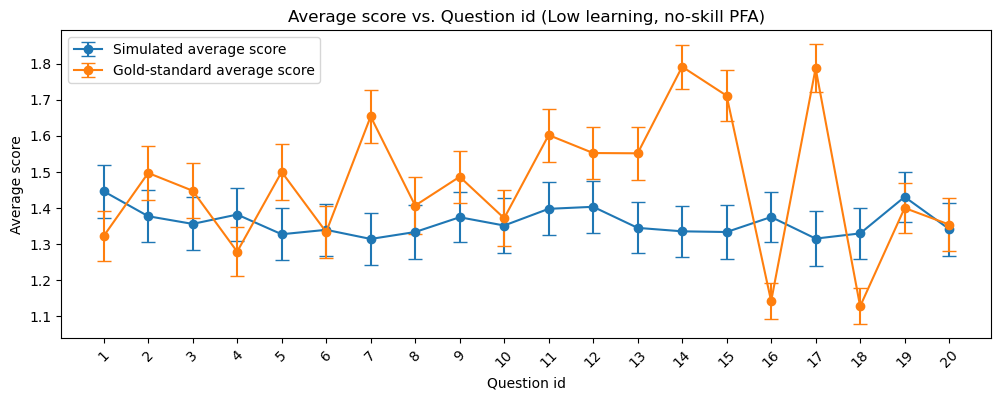

In [140]:
problem_id_list = sorted(LLNS_student_sequences['problem_id'].unique())
simulated_average_score_list = []
simulated_confidence_interval_list = []
gold_standard_average_score_list = []
gold_standard_confidence_interval_list = []

for problem_id in problem_id_list:
    simulated_score = LLNS_student_sequences[LLNS_student_sequences['problem_id'] == problem_id]['score']
    if len(simulated_score) > 0:
        mean_simulated_score = sum(simulated_score) / len(simulated_score)
        variance_simulated_score = sum((x - mean_simulated_score) ** 2 for x in simulated_score) / (len(simulated_score) - 1)
        standard_deviation_simulated_score = variance_simulated_score ** 0.5
        standard_error_simulated_score = standard_deviation_simulated_score / (len(simulated_score) ** 0.5)
        confidence_interval_simulated_score = 1.96 * standard_error_simulated_score
    else:
        mean_simulated_score = 0
        confidence_interval_simulated_score = 0
    simulated_average_score_list.append(mean_simulated_score)
    simulated_confidence_interval_list.append(confidence_interval_simulated_score)
    
    gold_standard_score = gold_standard_sequences[gold_standard_sequences['problem_id'] == problem_id]['score']
    if len(gold_standard_score) > 0:
        mean_gold = sum(gold_standard_score) / len(gold_standard_score)
        variance_gold = sum((x - mean_gold) ** 2 for x in gold_standard_score) / (len(gold_standard_score) - 1)
        standard_deviation_gold = variance_gold ** 0.5
        standard_error_gold = standard_deviation_gold / (len(gold_standard_score) ** 0.5)
        confidence_interval_gold = 1.96 * standard_error_gold
    else:
        mean_gold = 0
        confidence_interval_gold = 0
    gold_standard_average_score_list.append(mean_gold)
    gold_standard_confidence_interval_list.append(confidence_interval_gold)
        
# print("problem list length:", len(problem_id_list))
# print("simulated average score length:", len(simulated_average_score_list))
# print("gold-standard average score length:", len(gold_standard_average_score_list))
    
plt.figure(figsize=(12,4))
x = np.arange(len(problem_id_list))
plt.errorbar(x, simulated_average_score_list, yerr=simulated_confidence_interval_list, label = 'Simulated average score', fmt='o-', capsize=5)
plt.errorbar(x, gold_standard_average_score_list, yerr=gold_standard_confidence_interval_list, label = 'Gold-standard average score', fmt='o-', capsize=5)
plt.xticks(x, problem_id_list, rotation=45)
plt.xlabel('Question id')
plt.ylabel('Average score')
plt.title('Average score vs. Question id (Low learning, no-skill PFA)')
plt.legend()
plt.show()


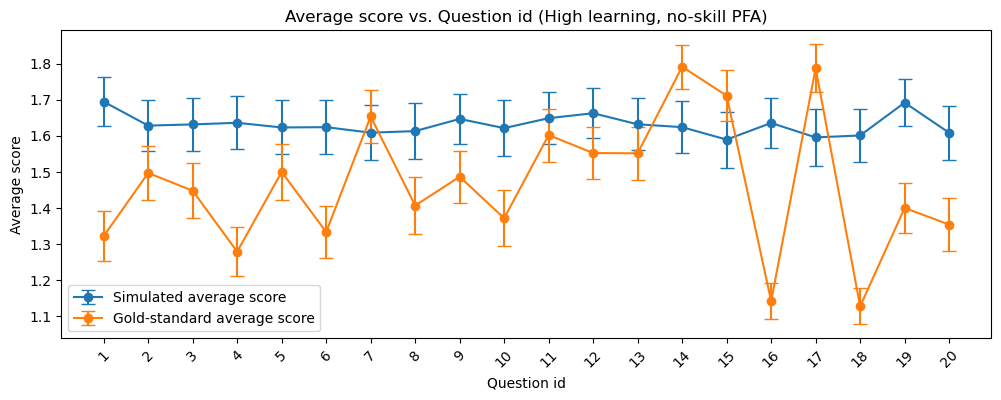

In [142]:
problem_id_list = sorted(HLNS_student_sequences['problem_id'].unique())
simulated_average_score_list = []
simulated_confidence_interval_list = []
gold_standard_average_score_list = []
gold_standard_confidence_interval_list = []

for problem_id in problem_id_list:
    simulated_score = HLNS_student_sequences[HLNS_student_sequences['problem_id'] == problem_id]['score']
    if len(simulated_score) > 0:
        mean_simulated_score = sum(simulated_score) / len(simulated_score)
        variance_simulated_score = sum((x - mean_simulated_score) ** 2 for x in simulated_score) / (len(simulated_score) - 1)
        standard_deviation_simulated_score = variance_simulated_score ** 0.5
        standard_error_simulated_score = standard_deviation_simulated_score / (len(simulated_score) ** 0.5)
        confidence_interval_simulated_score = 1.96 * standard_error_simulated_score
    else:
        mean_simulated_score = 0
        confidence_interval_simulated_score = 0
    simulated_average_score_list.append(mean_simulated_score)
    simulated_confidence_interval_list.append(confidence_interval_simulated_score)
    
    gold_standard_score = gold_standard_sequences[gold_standard_sequences['problem_id'] == problem_id]['score']
    if len(gold_standard_score) > 0:
        mean_gold = sum(gold_standard_score) / len(gold_standard_score)
        variance_gold = sum((x - mean_gold) ** 2 for x in gold_standard_score) / (len(gold_standard_score) - 1)
        standard_deviation_gold = variance_gold ** 0.5
        standard_error_gold = standard_deviation_gold / (len(gold_standard_score) ** 0.5)
        confidence_interval_gold = 1.96 * standard_error_gold
    else:
        mean_gold = 0
        confidence_interval_gold = 0
    gold_standard_average_score_list.append(mean_gold)
    gold_standard_confidence_interval_list.append(confidence_interval_gold)
    
plt.figure(figsize=(12,4))
x = np.arange(len(problem_id_list))
plt.errorbar(x, simulated_average_score_list, yerr=simulated_confidence_interval_list, label = 'Simulated average score', fmt='o-', capsize=5)
plt.errorbar(x, gold_standard_average_score_list, yerr=gold_standard_confidence_interval_list, label = 'Gold-standard average score', fmt='o-', capsize=5)
plt.xticks(x, problem_id_list, rotation=45)
plt.xlabel('Question id')
plt.ylabel('Average score')
plt.title('Average score vs. Question id (High learning, no-skill PFA)')
plt.legend()
plt.show()


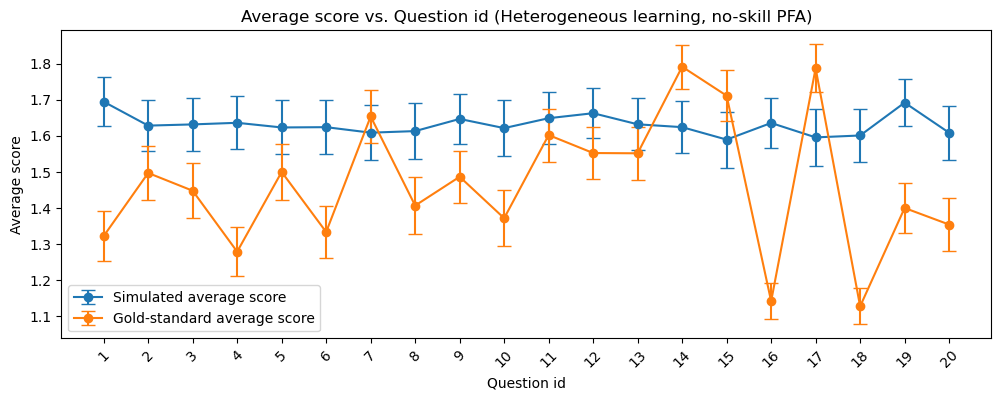

In [143]:
problem_id_list = sorted(HELNS_student_sequences['problem_id'].unique())
simulated_average_score_list = []
simulated_confidence_interval_list = []
gold_standard_average_score_list = []
gold_standard_confidence_interval_list = []

for problem_id in problem_id_list:
    simulated_score = HELNS_student_sequences[HELNS_student_sequences['problem_id'] == problem_id]['score']
    if len(simulated_score) > 0:
        mean_simulated_score = sum(simulated_score) / len(simulated_score)
        variance_simulated_score = sum((x - mean_simulated_score) ** 2 for x in simulated_score) / (len(simulated_score) - 1)
        standard_deviation_simulated_score = variance_simulated_score ** 0.5
        standard_error_simulated_score = standard_deviation_simulated_score / (len(simulated_score) ** 0.5)
        confidence_interval_simulated_score = 1.96 * standard_error_simulated_score
    else:
        mean_simulated_score = 0
        confidence_interval_simulated_score = 0
    simulated_average_score_list.append(mean_simulated_score)
    simulated_confidence_interval_list.append(confidence_interval_simulated_score)
    
    gold_standard_score = gold_standard_sequences[gold_standard_sequences['problem_id'] == problem_id]['score']
    if len(gold_standard_score) > 0:
        mean_gold = sum(gold_standard_score) / len(gold_standard_score)
        variance_gold = sum((x - mean_gold) ** 2 for x in gold_standard_score) / (len(gold_standard_score) - 1)
        standard_deviation_gold = variance_gold ** 0.5
        standard_error_gold = standard_deviation_gold / (len(gold_standard_score) ** 0.5)
        confidence_interval_gold = 1.96 * standard_error_gold
    else:
        mean_gold = 0
        confidence_interval_gold = 0
    gold_standard_average_score_list.append(mean_gold)
    gold_standard_confidence_interval_list.append(confidence_interval_gold)
    
plt.figure(figsize=(12,4))
x = np.arange(len(problem_id_list))
plt.errorbar(x, simulated_average_score_list, yerr=simulated_confidence_interval_list, label = 'Simulated average score', fmt='o-', capsize=5)
plt.errorbar(x, gold_standard_average_score_list, yerr=gold_standard_confidence_interval_list, label = 'Gold-standard average score', fmt='o-', capsize=5)
plt.xticks(x, problem_id_list, rotation=45)
plt.xlabel('Question id')
plt.ylabel('Average score')
plt.title('Average score vs. Question id (Heterogeneous learning, no-skill PFA)')
plt.legend()
plt.show()


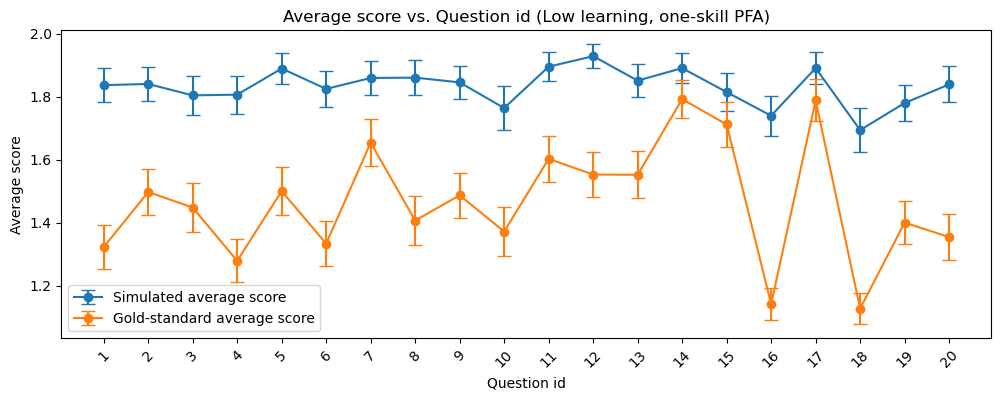

In [144]:
problem_id_list = sorted(LLOS_student_sequences['problem_id'].unique())
simulated_average_score_list = []
simulated_confidence_interval_list = []
gold_standard_average_score_list = []
gold_standard_confidence_interval_list = []

for problem_id in problem_id_list:
    simulated_score = LLOS_student_sequences[LLOS_student_sequences['problem_id'] == problem_id]['score']
    if len(simulated_score) > 0:
        mean_simulated_score = sum(simulated_score) / len(simulated_score)
        variance_simulated_score = sum((x - mean_simulated_score) ** 2 for x in simulated_score) / (len(simulated_score) - 1)
        standard_deviation_simulated_score = variance_simulated_score ** 0.5
        standard_error_simulated_score = standard_deviation_simulated_score / (len(simulated_score) ** 0.5)
        confidence_interval_simulated_score = 1.96 * standard_error_simulated_score
    else:
        mean_simulated_score = 0
        confidence_interval_simulated_score = 0
    simulated_average_score_list.append(mean_simulated_score)
    simulated_confidence_interval_list.append(confidence_interval_simulated_score)
    
    gold_standard_score = gold_standard_sequences[gold_standard_sequences['problem_id'] == problem_id]['score']
    if len(gold_standard_score) > 0:
        mean_gold = sum(gold_standard_score) / len(gold_standard_score)
        variance_gold = sum((x - mean_gold) ** 2 for x in gold_standard_score) / (len(gold_standard_score) - 1)
        standard_deviation_gold = variance_gold ** 0.5
        standard_error_gold = standard_deviation_gold / (len(gold_standard_score) ** 0.5)
        confidence_interval_gold = 1.96 * standard_error_gold
    else:
        mean_gold = 0
        confidence_interval_gold = 0
    gold_standard_average_score_list.append(mean_gold)
    gold_standard_confidence_interval_list.append(confidence_interval_gold)
    
plt.figure(figsize=(12,4))
x = np.arange(len(problem_id_list))
plt.errorbar(x, simulated_average_score_list, yerr=simulated_confidence_interval_list, label = 'Simulated average score', fmt='o-', capsize=5)
plt.errorbar(x, gold_standard_average_score_list, yerr=gold_standard_confidence_interval_list, label = 'Gold-standard average score', fmt='o-', capsize=5)
plt.xticks(x, problem_id_list, rotation=45)
plt.xlabel('Question id')
plt.ylabel('Average score')
plt.title('Average score vs. Question id (Low learning, one-skill PFA)')
plt.legend()
plt.show()


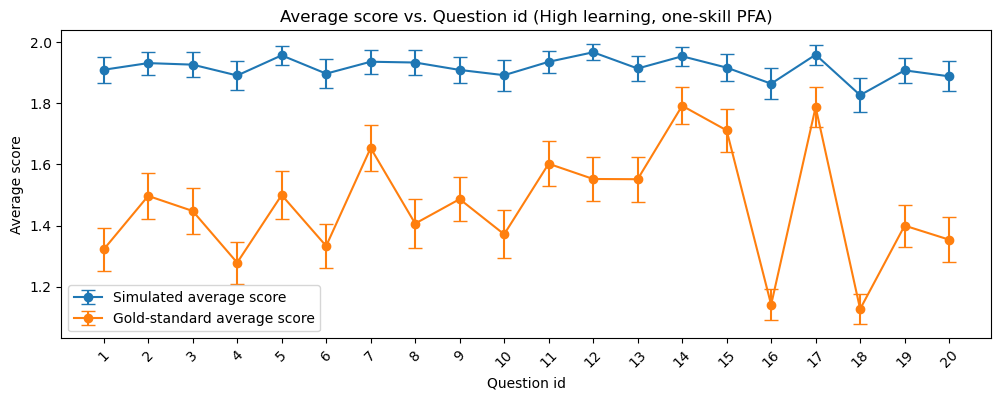

In [145]:
problem_id_list = sorted(HLOS_student_sequences['problem_id'].unique())
simulated_average_score_list = []
simulated_confidence_interval_list = []
gold_standard_average_score_list = []
gold_standard_confidence_interval_list = []

for problem_id in problem_id_list:
    simulated_score = HLOS_student_sequences[HLOS_student_sequences['problem_id'] == problem_id]['score']
    if len(simulated_score) > 0:
        mean_simulated_score = sum(simulated_score) / len(simulated_score)
        variance_simulated_score = sum((x - mean_simulated_score) ** 2 for x in simulated_score) / (len(simulated_score) - 1)
        standard_deviation_simulated_score = variance_simulated_score ** 0.5
        standard_error_simulated_score = standard_deviation_simulated_score / (len(simulated_score) ** 0.5)
        confidence_interval_simulated_score = 1.96 * standard_error_simulated_score
    else:
        mean_simulated_score = 0
        confidence_interval_simulated_score = 0
    simulated_average_score_list.append(mean_simulated_score)
    simulated_confidence_interval_list.append(confidence_interval_simulated_score)
    
    gold_standard_score = gold_standard_sequences[gold_standard_sequences['problem_id'] == problem_id]['score']
    if len(gold_standard_score) > 0:
        mean_gold = sum(gold_standard_score) / len(gold_standard_score)
        variance_gold = sum((x - mean_gold) ** 2 for x in gold_standard_score) / (len(gold_standard_score) - 1)
        standard_deviation_gold = variance_gold ** 0.5
        standard_error_gold = standard_deviation_gold / (len(gold_standard_score) ** 0.5)
        confidence_interval_gold = 1.96 * standard_error_gold
    else:
        mean_gold = 0
        confidence_interval_gold = 0
    gold_standard_average_score_list.append(mean_gold)
    gold_standard_confidence_interval_list.append(confidence_interval_gold)
    
plt.figure(figsize=(12,4))
x = np.arange(len(problem_id_list))
plt.errorbar(x, simulated_average_score_list, yerr=simulated_confidence_interval_list, label = 'Simulated average score', fmt='o-', capsize=5)
plt.errorbar(x, gold_standard_average_score_list, yerr=gold_standard_confidence_interval_list, label = 'Gold-standard average score', fmt='o-', capsize=5)
plt.xticks(x, problem_id_list, rotation=45)
plt.xlabel('Question id')
plt.ylabel('Average score')
plt.title('Average score vs. Question id (High learning, one-skill PFA)')
plt.legend()
plt.show()


### Figure 3

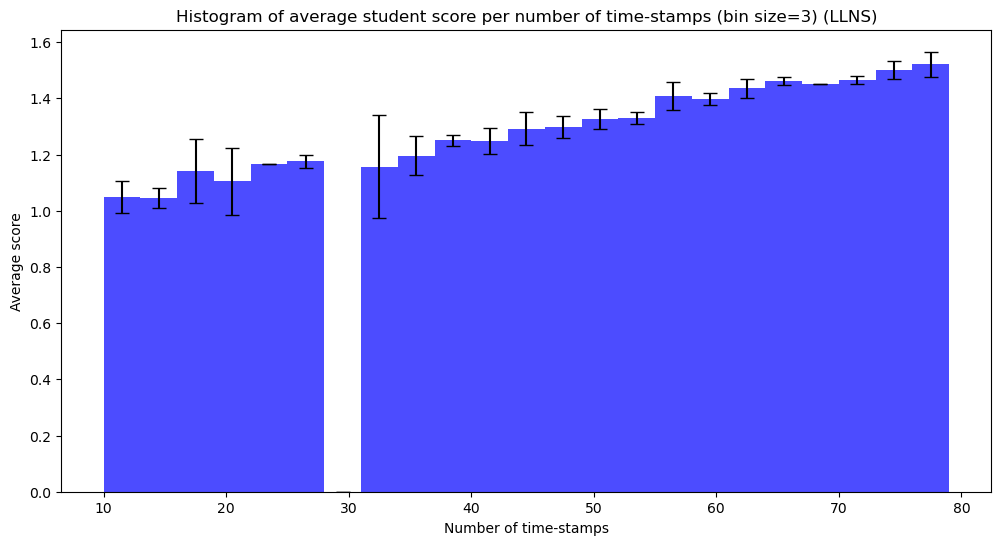

In [173]:
time_step_dict = {}
average_score_dict = {}
bin_size = 3

for student_id, group in LLNS_student_sequences.groupby('student_id'):
    time_step_dict[student_id] = len(group['time_step'])
    total_score = sum(group['score'])
    num_scores = len(group['score'])
    average_score_dict[student_id] = total_score / num_scores

student_group = pd.DataFrame({'student_id': list(time_step_dict.keys()), 'time_stamps': list(time_step_dict.values()), 'average_score': list(average_score_dict.values())})
min_time_stamps = student_group['time_stamps'].min()
max_time_stamps = student_group['time_stamps'].max()
bins = np.arange(min_time_stamps, max_time_stamps + bin_size, bin_size)
bin_mean_list = []
bin_confidence_interval_list = []

for i in range(len(bins) - 1):
    bin_data = student_group[(student_group['time_stamps'] >= bins[i]) & (student_group['time_stamps'] < bins[i + 1])]['average_score']
    num_bin_data = len(bin_data)
    
    if num_bin_data > 1:
        total_bin_score = sum(bin_data)
        bin_mean = total_bin_score / num_bin_data
        variance_sum = sum((x - bin_mean) ** 2 for x in bin_data)
        variance_bin = variance_sum / (num_bin_data - 1)
        standard_deviation_bin = variance_bin ** 0.5
        standard_error_bin = standard_deviation_bin / (num_bin_data ** 0.5)
        confidence_interval_bin = 1.96 * standard_error_bin
    elif num_bin_data == 1: 
        bin_mean = bin_data.iloc[0]
        confidence_interval_bin = 0
    else:  
        bin_mean = 0
        confidence_interval_bin = 0
    bin_mean_list.append(bin_mean)
    bin_confidence_interval_list.append(confidence_interval_bin)
bin_centers = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(12, 6))
plt.bar(bin_centers, bin_mean_list, width=bin_size, yerr=bin_confidence_interval_list, capsize=5, color='blue', alpha=0.7)
plt.xlabel('Number of time-stamps')
plt.ylabel('Average score')
plt.title(f'Histogram of average student score per number of time-stamps (bin size={bin_size}) (LLNS)')
plt.show()

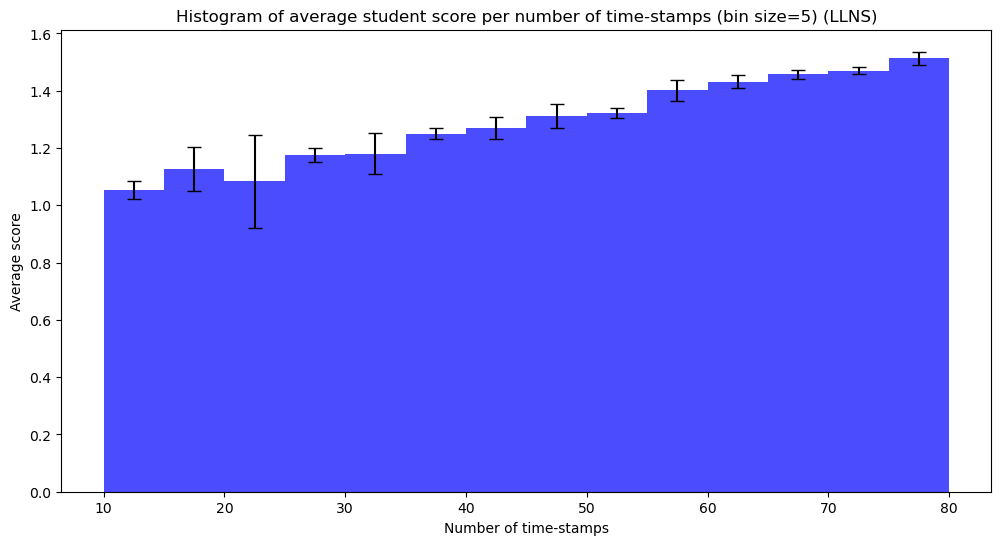

In [174]:
time_step_dict = {}
average_score_dict = {}
bin_size = 5

for student_id, group in LLNS_student_sequences.groupby('student_id'):
    time_step_dict[student_id] = len(group['time_step'])
    total_score = sum(group['score'])
    num_scores = len(group['score'])
    average_score_dict[student_id] = total_score / num_scores

student_group = pd.DataFrame({'student_id': list(time_step_dict.keys()), 'time_stamps': list(time_step_dict.values()), 'average_score': list(average_score_dict.values())})
min_time_stamps = student_group['time_stamps'].min()
max_time_stamps = student_group['time_stamps'].max()
bins = np.arange(min_time_stamps, max_time_stamps + bin_size, bin_size)
bin_mean_list = []
bin_confidence_interval_list = []

for i in range(len(bins) - 1):
    bin_data = student_group[(student_group['time_stamps'] >= bins[i]) & (student_group['time_stamps'] < bins[i + 1])]['average_score']
    num_bin_data = len(bin_data)
    
    if num_bin_data > 1:
        total_bin_score = sum(bin_data)
        bin_mean = total_bin_score / num_bin_data
        variance_sum = sum((x - bin_mean) ** 2 for x in bin_data)
        variance_bin = variance_sum / (num_bin_data - 1)
        standard_deviation_bin = variance_bin ** 0.5
        standard_error_bin = standard_deviation_bin / (num_bin_data ** 0.5)
        confidence_interval_bin = 1.96 * standard_error_bin
    elif num_bin_data == 1: 
        bin_mean = bin_data.iloc[0]
        confidence_interval_bin = 0
    else:  
        bin_mean = 0
        confidence_interval_bin = 0
    bin_mean_list.append(bin_mean)
    bin_confidence_interval_list.append(confidence_interval_bin)
bin_centers = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(12, 6))
plt.bar(bin_centers, bin_mean_list, width=bin_size, yerr=bin_confidence_interval_list, capsize=5, color='blue', alpha=0.7)
plt.xlabel('Number of time-stamps')
plt.ylabel('Average score')
plt.title(f'Histogram of average student score per number of time-stamps (bin size={bin_size}) (LLNS)')
plt.show()

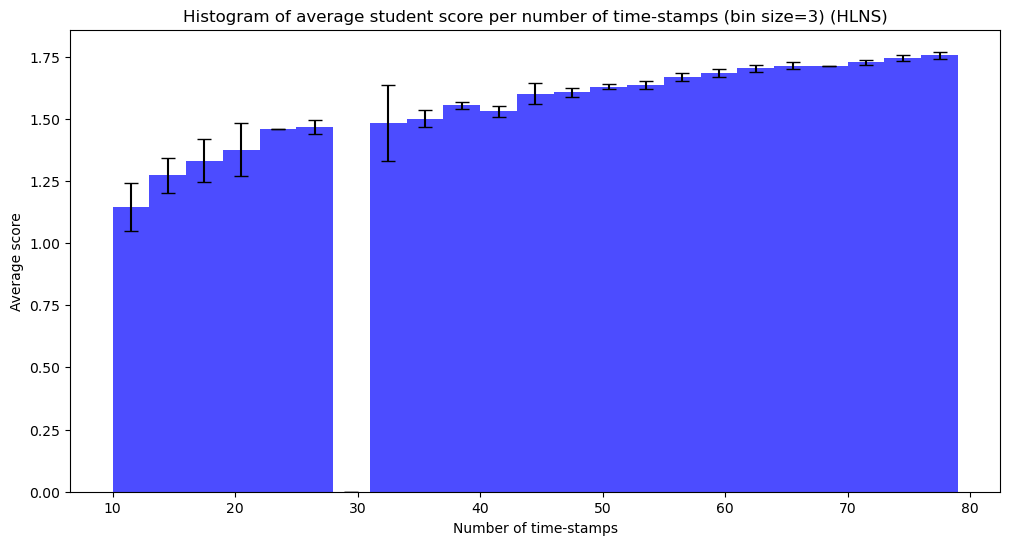

In [175]:
time_step_dict = {}
average_score_dict = {}
bin_size = 3

for student_id, group in HLNS_student_sequences.groupby('student_id'):
    time_step_dict[student_id] = len(group['time_step'])
    total_score = sum(group['score'])
    num_scores = len(group['score'])
    average_score_dict[student_id] = total_score / num_scores

student_group = pd.DataFrame({'student_id': list(time_step_dict.keys()), 'time_stamps': list(time_step_dict.values()), 'average_score': list(average_score_dict.values())})
min_time_stamps = student_group['time_stamps'].min()
max_time_stamps = student_group['time_stamps'].max()
bins = np.arange(min_time_stamps, max_time_stamps + bin_size, bin_size)
bin_mean_list = []
bin_confidence_interval_list = []

for i in range(len(bins) - 1):
    bin_data = student_group[(student_group['time_stamps'] >= bins[i]) & (student_group['time_stamps'] < bins[i + 1])]['average_score']
    num_bin_data = len(bin_data)
    
    if num_bin_data > 1:
        total_bin_score = sum(bin_data)
        bin_mean = total_bin_score / num_bin_data
        variance_sum = sum((x - bin_mean) ** 2 for x in bin_data)
        variance_bin = variance_sum / (num_bin_data - 1)
        standard_deviation_bin = variance_bin ** 0.5
        standard_error_bin = standard_deviation_bin / (num_bin_data ** 0.5)
        confidence_interval_bin = 1.96 * standard_error_bin
    elif num_bin_data == 1: 
        bin_mean = bin_data.iloc[0]
        confidence_interval_bin = 0
    else:  
        bin_mean = 0
        confidence_interval_bin = 0
    bin_mean_list.append(bin_mean)
    bin_confidence_interval_list.append(confidence_interval_bin)
bin_centers = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(12, 6))
plt.bar(bin_centers, bin_mean_list, width=bin_size, yerr=bin_confidence_interval_list, capsize=5, color='blue', alpha=0.7)
plt.xlabel('Number of time-stamps')
plt.ylabel('Average score')
plt.title(f'Histogram of average student score per number of time-stamps (bin size={bin_size}) (HLNS)')
plt.show()

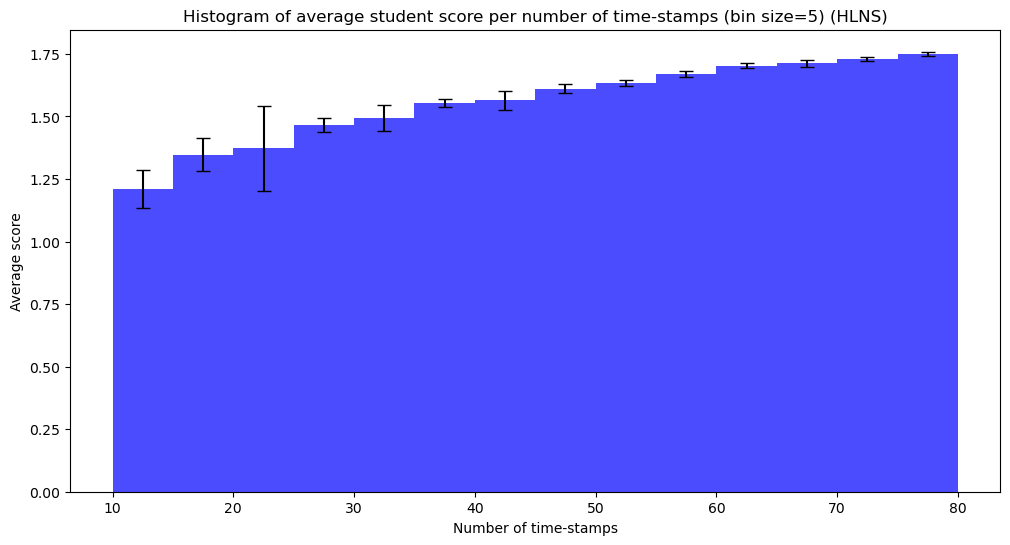

In [176]:
time_step_dict = {}
average_score_dict = {}
bin_size = 5

for student_id, group in HLNS_student_sequences.groupby('student_id'):
    time_step_dict[student_id] = len(group['time_step'])
    total_score = sum(group['score'])
    num_scores = len(group['score'])
    average_score_dict[student_id] = total_score / num_scores

student_group = pd.DataFrame({'student_id': list(time_step_dict.keys()), 'time_stamps': list(time_step_dict.values()), 'average_score': list(average_score_dict.values())})
min_time_stamps = student_group['time_stamps'].min()
max_time_stamps = student_group['time_stamps'].max()
bins = np.arange(min_time_stamps, max_time_stamps + bin_size, bin_size)
bin_mean_list = []
bin_confidence_interval_list = []

for i in range(len(bins) - 1):
    bin_data = student_group[(student_group['time_stamps'] >= bins[i]) & (student_group['time_stamps'] < bins[i + 1])]['average_score']
    num_bin_data = len(bin_data)
    
    if num_bin_data > 1:
        total_bin_score = sum(bin_data)
        bin_mean = total_bin_score / num_bin_data
        variance_sum = sum((x - bin_mean) ** 2 for x in bin_data)
        variance_bin = variance_sum / (num_bin_data - 1)
        standard_deviation_bin = variance_bin ** 0.5
        standard_error_bin = standard_deviation_bin / (num_bin_data ** 0.5)
        confidence_interval_bin = 1.96 * standard_error_bin
    elif num_bin_data == 1: 
        bin_mean = bin_data.iloc[0]
        confidence_interval_bin = 0
    else:  
        bin_mean = 0
        confidence_interval_bin = 0
    bin_mean_list.append(bin_mean)
    bin_confidence_interval_list.append(confidence_interval_bin)
bin_centers = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(12, 6))
plt.bar(bin_centers, bin_mean_list, width=bin_size, yerr=bin_confidence_interval_list, capsize=5, color='blue', alpha=0.7)
plt.xlabel('Number of time-stamps')
plt.ylabel('Average score')
plt.title(f'Histogram of average student score per number of time-stamps (bin size={bin_size}) (HLNS)')
plt.show()

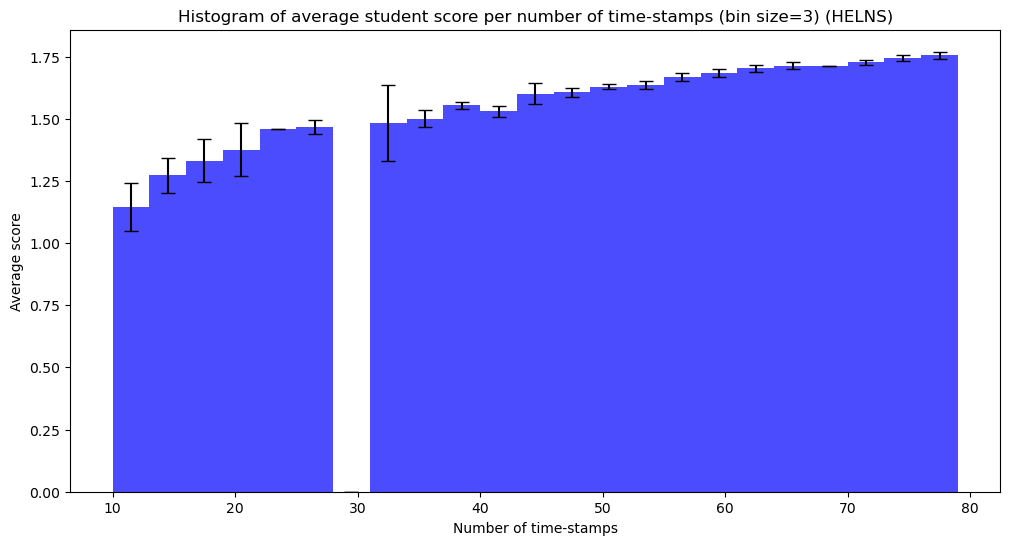

In [177]:
time_step_dict = {}
average_score_dict = {}
bin_size = 3

for student_id, group in HELNS_student_sequences.groupby('student_id'):
    time_step_dict[student_id] = len(group['time_step'])
    total_score = sum(group['score'])
    num_scores = len(group['score'])
    average_score_dict[student_id] = total_score / num_scores

student_group = pd.DataFrame({'student_id': list(time_step_dict.keys()), 'time_stamps': list(time_step_dict.values()), 'average_score': list(average_score_dict.values())})
min_time_stamps = student_group['time_stamps'].min()
max_time_stamps = student_group['time_stamps'].max()
bins = np.arange(min_time_stamps, max_time_stamps + bin_size, bin_size)
bin_mean_list = []
bin_confidence_interval_list = []

for i in range(len(bins) - 1):
    bin_data = student_group[(student_group['time_stamps'] >= bins[i]) & (student_group['time_stamps'] < bins[i + 1])]['average_score']
    num_bin_data = len(bin_data)
    
    if num_bin_data > 1:
        total_bin_score = sum(bin_data)
        bin_mean = total_bin_score / num_bin_data
        variance_sum = sum((x - bin_mean) ** 2 for x in bin_data)
        variance_bin = variance_sum / (num_bin_data - 1)
        standard_deviation_bin = variance_bin ** 0.5
        standard_error_bin = standard_deviation_bin / (num_bin_data ** 0.5)
        confidence_interval_bin = 1.96 * standard_error_bin
    elif num_bin_data == 1: 
        bin_mean = bin_data.iloc[0]
        confidence_interval_bin = 0
    else:  
        bin_mean = 0
        confidence_interval_bin = 0
    bin_mean_list.append(bin_mean)
    bin_confidence_interval_list.append(confidence_interval_bin)
bin_centers = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(12, 6))
plt.bar(bin_centers, bin_mean_list, width=bin_size, yerr=bin_confidence_interval_list, capsize=5, color='blue', alpha=0.7)
plt.xlabel('Number of time-stamps')
plt.ylabel('Average score')
plt.title(f'Histogram of average student score per number of time-stamps (bin size={bin_size}) (HELNS)')
plt.show()

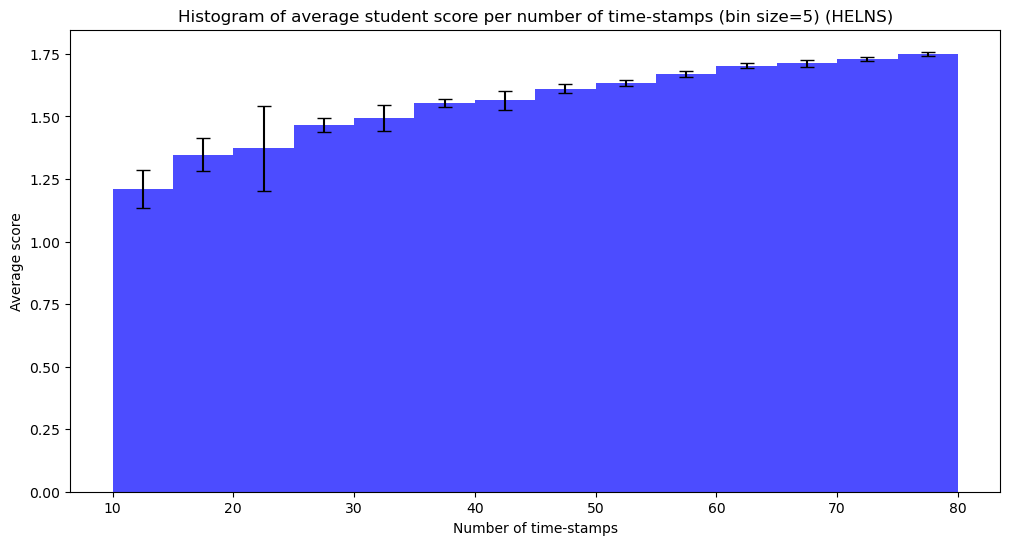

In [178]:
time_step_dict = {}
average_score_dict = {}
bin_size = 5

for student_id, group in HELNS_student_sequences.groupby('student_id'):
    time_step_dict[student_id] = len(group['time_step'])
    total_score = sum(group['score'])
    num_scores = len(group['score'])
    average_score_dict[student_id] = total_score / num_scores

student_group = pd.DataFrame({'student_id': list(time_step_dict.keys()), 'time_stamps': list(time_step_dict.values()), 'average_score': list(average_score_dict.values())})
min_time_stamps = student_group['time_stamps'].min()
max_time_stamps = student_group['time_stamps'].max()
bins = np.arange(min_time_stamps, max_time_stamps + bin_size, bin_size)
bin_mean_list = []
bin_confidence_interval_list = []

for i in range(len(bins) - 1):
    bin_data = student_group[(student_group['time_stamps'] >= bins[i]) & (student_group['time_stamps'] < bins[i + 1])]['average_score']
    num_bin_data = len(bin_data)
    
    if num_bin_data > 1:
        total_bin_score = sum(bin_data)
        bin_mean = total_bin_score / num_bin_data
        variance_sum = sum((x - bin_mean) ** 2 for x in bin_data)
        variance_bin = variance_sum / (num_bin_data - 1)
        standard_deviation_bin = variance_bin ** 0.5
        standard_error_bin = standard_deviation_bin / (num_bin_data ** 0.5)
        confidence_interval_bin = 1.96 * standard_error_bin
    elif num_bin_data == 1: 
        bin_mean = bin_data.iloc[0]
        confidence_interval_bin = 0
    else:  
        bin_mean = 0
        confidence_interval_bin = 0
    bin_mean_list.append(bin_mean)
    bin_confidence_interval_list.append(confidence_interval_bin)
bin_centers = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(12, 6))
plt.bar(bin_centers, bin_mean_list, width=bin_size, yerr=bin_confidence_interval_list, capsize=5, color='blue', alpha=0.7)
plt.xlabel('Number of time-stamps')
plt.ylabel('Average score')
plt.title(f'Histogram of average student score per number of time-stamps (bin size={bin_size}) (HELNS)')
plt.show()

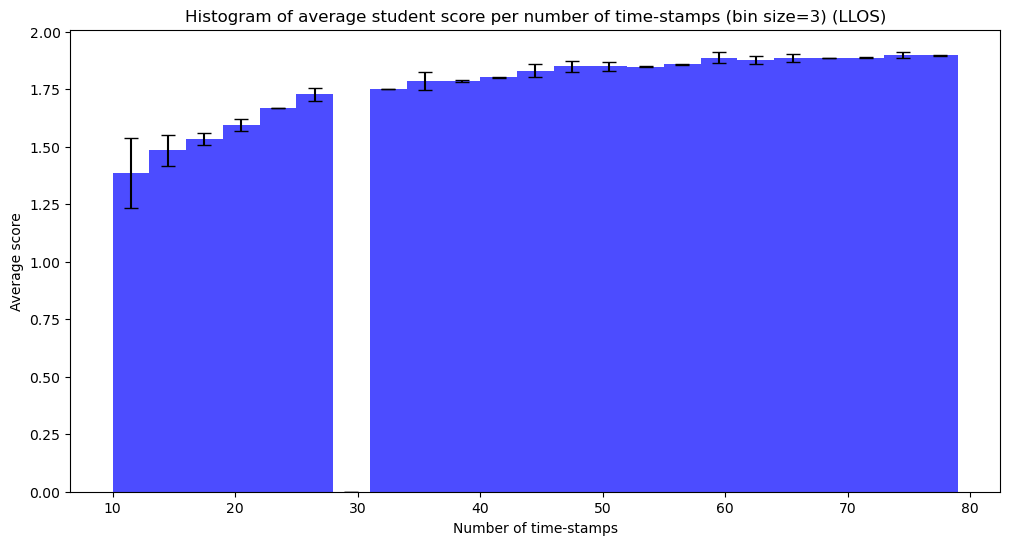

In [179]:
time_step_dict = {}
average_score_dict = {}
bin_size = 3

for student_id, group in LLOS_student_sequences.groupby('student_id'):
    time_step_dict[student_id] = len(group['time_step'])
    total_score = sum(group['score'])
    num_scores = len(group['score'])
    average_score_dict[student_id] = total_score / num_scores

student_group = pd.DataFrame({'student_id': list(time_step_dict.keys()), 'time_stamps': list(time_step_dict.values()), 'average_score': list(average_score_dict.values())})
min_time_stamps = student_group['time_stamps'].min()
max_time_stamps = student_group['time_stamps'].max()
bins = np.arange(min_time_stamps, max_time_stamps + bin_size, bin_size)
bin_mean_list = []
bin_confidence_interval_list = []

for i in range(len(bins) - 1):
    bin_data = student_group[(student_group['time_stamps'] >= bins[i]) & (student_group['time_stamps'] < bins[i + 1])]['average_score']
    num_bin_data = len(bin_data)
    
    if num_bin_data > 1:
        total_bin_score = sum(bin_data)
        bin_mean = total_bin_score / num_bin_data
        variance_sum = sum((x - bin_mean) ** 2 for x in bin_data)
        variance_bin = variance_sum / (num_bin_data - 1)
        standard_deviation_bin = variance_bin ** 0.5
        standard_error_bin = standard_deviation_bin / (num_bin_data ** 0.5)
        confidence_interval_bin = 1.96 * standard_error_bin
    elif num_bin_data == 1: 
        bin_mean = bin_data.iloc[0]
        confidence_interval_bin = 0
    else:  
        bin_mean = 0
        confidence_interval_bin = 0
    bin_mean_list.append(bin_mean)
    bin_confidence_interval_list.append(confidence_interval_bin)
bin_centers = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(12, 6))
plt.bar(bin_centers, bin_mean_list, width=bin_size, yerr=bin_confidence_interval_list, capsize=5, color='blue', alpha=0.7)
plt.xlabel('Number of time-stamps')
plt.ylabel('Average score')
plt.title(f'Histogram of average student score per number of time-stamps (bin size={bin_size}) (LLOS)')
plt.show()

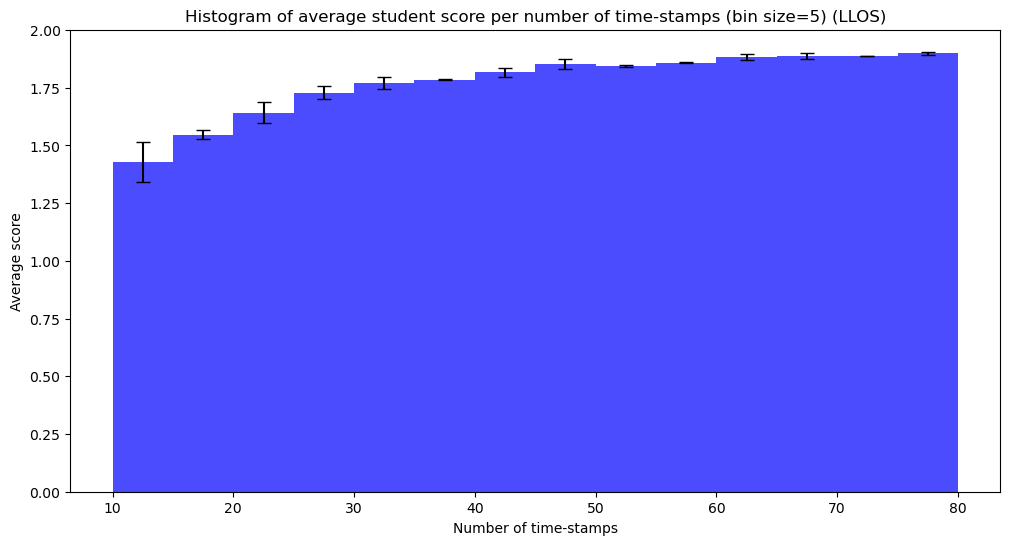

In [180]:
time_step_dict = {}
average_score_dict = {}
bin_size = 5

for student_id, group in LLOS_student_sequences.groupby('student_id'):
    time_step_dict[student_id] = len(group['time_step'])
    total_score = sum(group['score'])
    num_scores = len(group['score'])
    average_score_dict[student_id] = total_score / num_scores

student_group = pd.DataFrame({'student_id': list(time_step_dict.keys()), 'time_stamps': list(time_step_dict.values()), 'average_score': list(average_score_dict.values())})
min_time_stamps = student_group['time_stamps'].min()
max_time_stamps = student_group['time_stamps'].max()
bins = np.arange(min_time_stamps, max_time_stamps + bin_size, bin_size)
bin_mean_list = []
bin_confidence_interval_list = []

for i in range(len(bins) - 1):
    bin_data = student_group[(student_group['time_stamps'] >= bins[i]) & (student_group['time_stamps'] < bins[i + 1])]['average_score']
    num_bin_data = len(bin_data)
    
    if num_bin_data > 1:
        total_bin_score = sum(bin_data)
        bin_mean = total_bin_score / num_bin_data
        variance_sum = sum((x - bin_mean) ** 2 for x in bin_data)
        variance_bin = variance_sum / (num_bin_data - 1)
        standard_deviation_bin = variance_bin ** 0.5
        standard_error_bin = standard_deviation_bin / (num_bin_data ** 0.5)
        confidence_interval_bin = 1.96 * standard_error_bin
    elif num_bin_data == 1: 
        bin_mean = bin_data.iloc[0]
        confidence_interval_bin = 0
    else:  
        bin_mean = 0
        confidence_interval_bin = 0
    bin_mean_list.append(bin_mean)
    bin_confidence_interval_list.append(confidence_interval_bin)
bin_centers = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(12, 6))
plt.bar(bin_centers, bin_mean_list, width=bin_size, yerr=bin_confidence_interval_list, capsize=5, color='blue', alpha=0.7)
plt.xlabel('Number of time-stamps')
plt.ylabel('Average score')
plt.title(f'Histogram of average student score per number of time-stamps (bin size={bin_size}) (LLOS)')
plt.show()

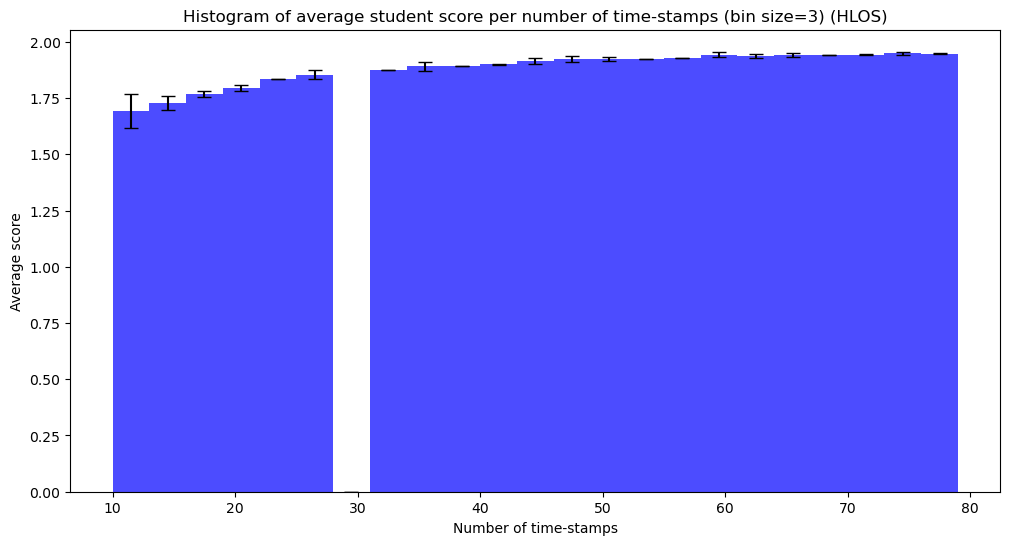

In [181]:
time_step_dict = {}
average_score_dict = {}
bin_size = 3

for student_id, group in HLOS_student_sequences.groupby('student_id'):
    time_step_dict[student_id] = len(group['time_step'])
    total_score = sum(group['score'])
    num_scores = len(group['score'])
    average_score_dict[student_id] = total_score / num_scores

student_group = pd.DataFrame({'student_id': list(time_step_dict.keys()), 'time_stamps': list(time_step_dict.values()), 'average_score': list(average_score_dict.values())})
min_time_stamps = student_group['time_stamps'].min()
max_time_stamps = student_group['time_stamps'].max()
bins = np.arange(min_time_stamps, max_time_stamps + bin_size, bin_size)
bin_mean_list = []
bin_confidence_interval_list = []

for i in range(len(bins) - 1):
    bin_data = student_group[(student_group['time_stamps'] >= bins[i]) & (student_group['time_stamps'] < bins[i + 1])]['average_score']
    num_bin_data = len(bin_data)
    
    if num_bin_data > 1:
        total_bin_score = sum(bin_data)
        bin_mean = total_bin_score / num_bin_data
        variance_sum = sum((x - bin_mean) ** 2 for x in bin_data)
        variance_bin = variance_sum / (num_bin_data - 1)
        standard_deviation_bin = variance_bin ** 0.5
        standard_error_bin = standard_deviation_bin / (num_bin_data ** 0.5)
        confidence_interval_bin = 1.96 * standard_error_bin
    elif num_bin_data == 1: 
        bin_mean = bin_data.iloc[0]
        confidence_interval_bin = 0
    else:  
        bin_mean = 0
        confidence_interval_bin = 0
    bin_mean_list.append(bin_mean)
    bin_confidence_interval_list.append(confidence_interval_bin)
bin_centers = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(12, 6))
plt.bar(bin_centers, bin_mean_list, width=bin_size, yerr=bin_confidence_interval_list, capsize=5, color='blue', alpha=0.7)
plt.xlabel('Number of time-stamps')
plt.ylabel('Average score')
plt.title(f'Histogram of average student score per number of time-stamps (bin size={bin_size}) (HLOS)')
plt.show()

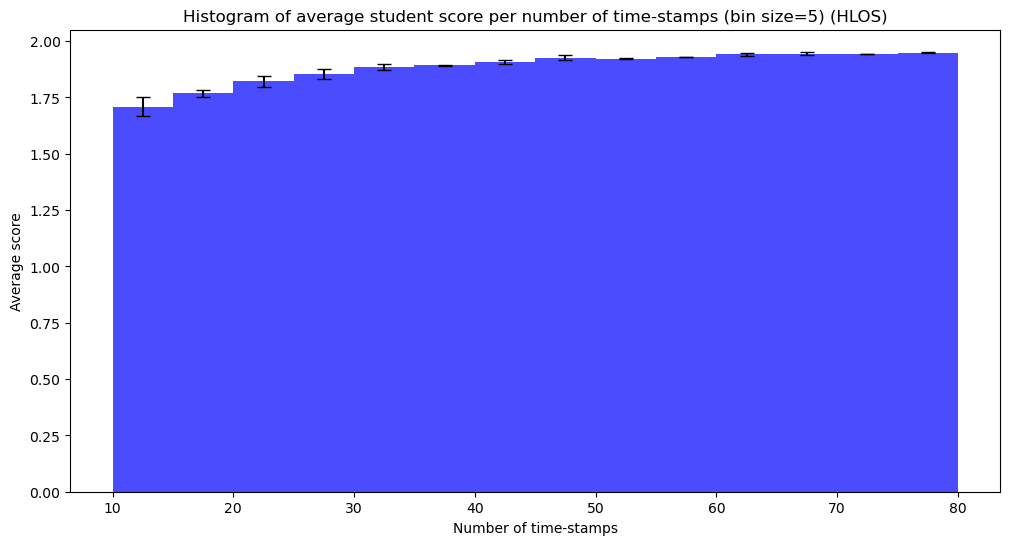

In [185]:
time_step_dict = {}
average_score_dict = {}
bin_size = 5

for student_id, group in HLOS_student_sequences.groupby('student_id'):
    time_step_dict[student_id] = len(group['time_step'])
    total_score = sum(group['score'])
    num_scores = len(group['score'])
    average_score_dict[student_id] = total_score / num_scores

student_group = pd.DataFrame({'student_id': list(time_step_dict.keys()), 'time_stamps': list(time_step_dict.values()), 'average_score': list(average_score_dict.values())})
min_time_stamps = student_group['time_stamps'].min()
max_time_stamps = student_group['time_stamps'].max()
bins = np.arange(min_time_stamps, max_time_stamps + bin_size, bin_size)
bin_mean_list = []
bin_confidence_interval_list = []

for i in range(len(bins) - 1):
    bin_data = student_group[(student_group['time_stamps'] >= bins[i]) & (student_group['time_stamps'] < bins[i + 1])]['average_score']
    num_bin_data = len(bin_data)
    
    if num_bin_data > 1:
        total_bin_score = sum(bin_data)
        bin_mean = total_bin_score / num_bin_data
        variance_sum = sum((x - bin_mean) ** 2 for x in bin_data)
        variance_bin = variance_sum / (num_bin_data - 1)
        standard_deviation_bin = variance_bin ** 0.5
        standard_error_bin = standard_deviation_bin / (num_bin_data ** 0.5)
        confidence_interval_bin = 1.96 * standard_error_bin
    elif num_bin_data == 1: 
        bin_mean = bin_data.iloc[0]
        confidence_interval_bin = 0
    else:  
        bin_mean = 0
        confidence_interval_bin = 0
    bin_mean_list.append(bin_mean)
    bin_confidence_interval_list.append(confidence_interval_bin)
bin_centers = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(12, 6))
plt.bar(bin_centers, bin_mean_list, width=bin_size, yerr=bin_confidence_interval_list, capsize=5, color='blue', alpha=0.7)
plt.xlabel('Number of time-stamps')
plt.ylabel('Average score')
plt.title(f'Histogram of average student score per number of time-stamps (bin size={bin_size}) (HLOS)')
plt.show()